# Feedback RAG system

In [ ]:
# For gkv-code

In [1]:
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sentence_transformers

# For lm-enforcer
#!pip install lm-format-enforcer
#!pip install --upgrade typing_extensions

# For flash-attn
#!pip install flash-attn --no-build-isolation

# For vLLM
!pip install vllm
!pip install ray
!pip install packaging
!pip install typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 17.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from huggingface_hub import notebook_login
notebook_login()

## Make chunks

### For code

In [3]:
# parameters
database_name = "gkv-code" # a directory named this must be in "data" folder
#extensions = [".py", ".h", ".cpp", ".cs"]

# take out all the files with 'extensions' inside 'folder_path'
file_info = [
    {"folder_path":"./data/gkv-code/src", "extensions":[".f90"]},
    {"folder_path":"./data/gkv-code/run", "extensions":["", ".q"]},
    {"folder_path":"./data/gkv-code/lib", "extensions":[".f90"]},
    {"folder_path":"./data/gkv-code", "extensions":[".txt",".md"]},
]

model_id = "gpt2"  #"cyberagent/calm2-7b-chat"
max_tokens = 1000
min_tokens = 300

# about where the key starts to split the text

# index : words to be where text should be split
# first element(0 to 1): process_text_size * element is the start point of the key splitting. the samller the element is, the more likely it is for the key to split the text.
# second element(0 or 1): the first element should become   if 0: <text1><key> | <text2>,  if 1: <text1> | <key><text2>
rules = [
    {
        "SUBROUTINE " : 1,
        #"class " : 1,
    },

    {
        #"def " : 1,
        #"void " : 1,
    },

    {
        "if " : 1,
        "end if" : 0,
    },

    {
        #"else " : 1,
        #"elif " : 1,
    },
    

    {
        "\n\n" : 0,
        "<0x0A><0x0A>" : 0,
        "\x0A\x0A" : 0,
    },

    {
        "\n" : 0,
        "<0x0A>" : 0,
        "\x0A" : 0,
    },
]

# if text is split by any in rules[warning_id:], split_into_chunks function returns warning = 1, otherwise warning = 0
warning_id = 3

In [5]:
import os
import json

from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, 
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,)

if not os.path.exists("processed"):
    os.makedirs("processed")
    
if not os.path.exists(f"processed/{database_name}"):
    os.makedirs(f"processed/{database_name}")

"""
file_paths = []
directory = "data/" + database_name
for root, dirnames, filenames in os.walk(directory):
    for filename in filenames:
        for extension in extensions:
            if filename.endswith(extension):
                file_paths.append(os.path.join(root, filename))
"""

file_paths = []
for i in range(len(file_info)):
    filenames_in_a_directory = os.listdir(file_info[i]["folder_path"])
    for file_name in filenames_in_a_directory:
        for extension in file_info[i]["extensions"]:
            if file_name.endswith(extension):
                path = os.path.join(file_info[i]["folder_path"], file_name)
                if not os.path.isdir(path):
                    file_paths.append(path)


def split_into_chunks(tokenizer, text, max_tokens, min_tokens, rules, debug):
    chunk_list = []
    instruction_list = []
    warnings = []
    split_rule_keys = []
    
    start_id = 0
    tokenized_text = tokenizer(text, return_tensors="pt", add_special_tokens = False)
    num_tokens = len(tokenized_text["input_ids"][0])
    text_size = len(text)
    
    for i in range(int(num_tokens/min_tokens)+1):
        
        if(start_id + max_tokens >= num_tokens):
            process_tokenized_text = tokenized_text["input_ids"][0][start_id:]
            processed_text = tokenizer.decode(process_tokenized_text, skip_special_tokens=True)
            chunk_list.append(processed_text)
            instruction_list.append(processed_text)
            warnings.append(0)
            split_rule_keys.append("[END]")
            break
            
        process_tokenized_text = tokenized_text["input_ids"][0][start_id : start_id + max_tokens]
        process_text = tokenizer.decode(process_tokenized_text, skip_special_tokens=True) # this should be decoded since subword token is difficult to handle
        process_text_size = len(process_text)

        #determine where should be split
        min_split_text = process_text_size
        is_text_split = False
        warning = 1
        for j in range(len(rules)):
            for rule_key in rules[j].keys():
                split_process_text = process_text.split(rule_key)
                if len(split_process_text) > 1:
                    size_last_split_process_text = len(split_process_text[-1])
                    if (size_last_split_process_text < min_split_text) and (size_last_split_process_text < (1 - min_tokens/max_tokens)*process_text_size) and (size_last_split_process_text!=process_text_size):
                        is_text_split = True
                        split_rule_key = rule_key
                        min_split_text = size_last_split_process_text + len(rule_key) * rules[j][rule_key]

                        if debug:
                            print("=====")
                            print("rule_key", rule_key)
                            print()
                            print("j: ", j)
                            print()
                            print("process_text[:-min_split_text]: ", process_text[:-min_split_text])
                            print()
                            print("process_text[-min_split_text:]: ", process_text[-min_split_text:])
                            print()

                        
                        break # this is supposed to be unnecessary, but I saw some weird thing without this for some reason. This cause must be figured out at some point
                        

            
            if is_text_split:
                if j < warning_id: warning = 0
                break
                        
        if is_text_split:
            processed_text = process_text[:-min_split_text]
            split_rule_keys.append(rule_key)
        else:
            processed_text = process_text
            split_rule_keys.append("")
        
        processed_tokenized_text = tokenizer(processed_text, return_tensors="pt", add_special_tokens = False)
        len_processed_text = len(processed_tokenized_text["input_ids"][0])  #this could be more than max_tokens without min sentence, which caused fatal error

        if len(processed_text)==0:
            break

        chunk_list.append(processed_text)  
        instruction_list.append(processed_text)
        warnings.append(warning)
        
        start_id += len_processed_text # taking from process_tokenized_text to prevent the id from getting wrong

    return chunk_list, instruction_list, warnings, split_rule_keys

from datasets import Dataset, DatasetDict
import time

start = time.time()

all_chunks = []
all_file_paths = []
chunk_dict = {}
split_rule_dict = {}
warning_chunk_dict = {}

for file_path in file_paths:
    with open(file_path) as f:
        text = f.read()
    debug = False
    if file_path == "./data/transformers/src/transformers/modeling_outputs.py":
        debug = True
        
    chunks, insts, warnings, split_rule_keys = split_into_chunks(tokenizer, text, max_tokens, min_tokens, rules, debug)
    
    all_chunks += chunks
    fp = [file_path for i in range(len(chunks))]
    all_file_paths += fp
    
    for i in range(len(chunks)):
        chunk_dict[file_path] = chunks
        #if file_path in chunk_dict: chunk_dict[file_path][file_path+str(i)] = chunks[i]
        #else: chunk_dict[file_path] = {file_path+str(i):chunks[i]}
        
        if warnings[i] == 1: warning_chunk_dict[file_path+str(i)] = chunks[i]

        split_rule_dict[file_path] = split_rule_keys
    
end = time.time()

print("total num chunk: ", len(all_chunks))
print("process time: ", end - start)


input_file_path = f"processed/{database_name}/chunks.json"
with open(input_file_path, 'w') as json_file:
    json.dump(all_chunks, json_file)

file_path_json = f"processed/{database_name}/file_paths.json"
with open(file_path_json, 'w') as json_file:
    json.dump(all_file_paths, json_file)

file_path_json = f"processed/{database_name}/chunk_dict.json"
with open(file_path_json, 'w') as json_file:
    json.dump(chunk_dict, json_file)
    
print("file saved")

# chunks: [<str> chunk of the text, ...]
# insts: [<str> instructions corresponds to chunk, ...]



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (35892 > 1024). Running this sequence through the model will result in indexing errors


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 560: invalid start byte

### For papers

In [5]:
# parameters

database_name = "gkv-papers" # a directory named this must be in "data" folder
extensions = [".tex"]
image_extensions = [".jpg"]
model_id = "mistralai/Mistral-7B-Instruct-v0.2"  #"cyberagent/calm2-7b-chat"
max_tokens = 2000
min_tokens = 30


# about where the key starts to split the text

# index : words to be where text should be splited
# first element(0 to 1): process_text_size*element is the start point of the key splitting. the samller the element is, the more likely it is for the key to split the text.
# second element(0 or 1): the first element should become   if 0: <text1><key> | <text2>,  if 1: <text1> | <key><text2>
rules = [
    {
        "\\\\section*" : 1,
    },

    {
        "\\\\subsection*" : 1,
    },

    {
        "\\\\begin{center}" : 1,
        "\\\\end{gather*}" : 0,
        "\\\\end{align*}" : 0,   
        "\\\\end{equation*}" : 0,
        "\\\\end{enumerate}" : 0,
    },

    {
        "\n\n" : 0,
        "<0x0A><0x0A>" : 0,
        "\x0A\x0A" : 0,
    },

    {
        "\n" : 0,
        "<0x0A>" : 0,
        "\x0A" : 0,
    },
]

# 注：latexで\\となっているところでsplitしたい場合、ruleのkeyには\\\\と記述しないといけない

In [ ]:
import os
import json

from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, 
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,)

if not os.path.exists("chunks"):
    os.makedirs("chunks")

if not os.path.exists("file_paths"):
    os.makedirs("file_paths")

file_paths = []
directory = "data/" + database_name
for root, dirnames, filenames in os.walk(directory):
    for filename in filenames:
        for extension in extensions:
            if filename.endswith(extension):
                file_paths.append(os.path.join(root, filename))


def split_into_chunks(tokenizer, text, max_tokens, min_tokens, rules):
    chunk_list = []
    instruction_list = []
    
    start_id = 0
    tokenized_text = tokenizer(text, return_tensors="pt", add_special_tokens = False)
    num_tokens = len(tokenized_text["input_ids"][0])
    text_size = len(text)
    
    for i in range(int(num_tokens/min_tokens)+1):
        if(start_id + max_tokens >= num_tokens):
            process_tokenized_text = tokenized_text["input_ids"][0][start_id:]
            processed_text = tokenizer.decode(process_tokenized_text, skip_special_tokens=True)
            chunk_list.append(processed_text)
            instruction_list.append(processed_text)
            break
            
        process_tokenized_text = tokenized_text["input_ids"][0][start_id : start_id + max_tokens]
        process_text = tokenizer.decode(process_tokenized_text, skip_special_tokens=True) # this should be decoded since subword token is difficult to handle
        process_text_size = len(process_text)

        #determine where should be split
        min_split_text = process_text_size
        is_text_split = False
        for rule_group in rules:
            for rule_key in rule_group.keys():
                split_process_text = process_text.split(rule_key)
                if len(split_process_text) > 1:
                    size_last_split_process_text = len(split_process_text[-1])
                    if (size_last_split_process_text < min_split_text) and (size_last_split_process_text < (1 - min_tokens/max_tokens)*process_text_size) and (size_last_split_process_text!=process_text_size):
                        is_text_split = True
                        min_split_text = size_last_split_process_text + len(rule_key) * rule_group[rule_key]

            if is_text_split:
                break
                        
        if is_text_split:
            processed_text = process_text[:-min_split_text]
        else:
            processed_text = process_text

        
        processed_tokenized_text = tokenizer(processed_text, return_tensors="pt", add_special_tokens = False)
        len_processed_text = len(processed_tokenized_text["input_ids"][0])  #this could be more than max_tokens without min sentence, which caused fatal error

        if len(processed_text)==0:
            break
            
        chunk_list.append(processed_text)  
        instruction_list.append(processed_text)
        
        start_id += len_processed_text # taking from process_tokenized_text to prevent the id from getting wrong

    return chunk_list, instruction_list

from datasets import Dataset, DatasetDict
import time

start = time.time()

all_chunks = []
all_file_paths = []
for file_path in file_paths:
    with open(file_path) as f:
        text = f.read()
    
    chunks, insts = split_into_chunks(tokenizer, text, max_tokens, min_tokens, rules)
    
    all_chunks += chunks
    fp = [file_path for i in range(len(chunks))]
    all_file_paths += fp
    
end = time.time()

print("total num chunk: ", len(all_chunks))
print("process time: ", end - start)


input_file_path = "chunks/" + database_name + ".json"
with open(input_file_path, 'w') as json_file:
    json.dump(all_chunks, json_file)

file_path_json = "file_paths/" + database_name + ".json"
with open(file_path_json, 'w') as json_file:
    json.dump(all_file_paths, json_file)
    
print("file saved")

# chunks: [<str> chunk of the text, ...]
# insts: [<str> instructions corresponds to chunk, ...]



In [7]:
# image processing
import shutil
import os
import json

def copy_file(source, destination):
    try:
        shutil.copy(source, destination)
    except:
        print("Unexpected error:", sys.exc_info())


image_file_paths = []
directory = "data/" + database_name
for root, dirnames, filenames in os.walk(directory):
    for filename in filenames:
        for extension in image_extensions:
            if filename.endswith(extension):
                image_file_paths.append(os.path.join(root, filename))


if not os.path.exists("images"):
    os.makedirs("images")
if not os.path.exists("image_names"):
    os.makedirs("image_names")

image_names = []

for file_path in image_file_paths:
    source_file = file_path
    destination_file = "images/" + os.path.basename(file_path)
    image_names.append(os.path.basename(file_path))
    
    copy_file(source_file, destination_file)

with open(f"image_names/{database_name}.json", "w") as json_file:
    json.dump(image_names, json_file)

print("save finished")

save finished


### For textbooks

In [4]:
# parameters

database_name = "gkv-papers" # a directory named this must be in "data" folder
extensions = [".tex"]
model_id = "mistralai/Mistral-7B-Instruct-v0.2"  #"cyberagent/calm2-7b-chat"
max_tokens = 2000
min_tokens = 30


# about where the key starts to split the text

# index : words to be where text should be splited
# first element(0 to 1): process_text_size*element is the start point of the key splitting. the samller the element is, the more likely it is for the key to split the text.
# second element(0 or 1): the first element should become   if 0: <text1><key> | <text2>,  if 1: <text1> | <key><text2>
rules = [
    {
        "\\\\section*" : 1,
    },

    {
        "\\\\subsection*" : 1,
    },

    {
        "\\\\begin{center}" : 1,
        "\\\\end{gather*}" : 0,
        "\\\\end{align*}" : 0,   
        "\\\\end{equation*}" : 0,
        "\\\\end{enumerate}" : 0,
    },

    {
        "\n\n" : 0,
        "<0x0A><0x0A>" : 0,
        "\x0A\x0A" : 0,
    },

    {
        "\n" : 0,
        "<0x0A>" : 0,
        "\x0A" : 0,
    },
]

# 注：latexで\\となっているところでsplitしたい場合、ruleのkeyには\\\\と記述しないといけない

In [5]:
import os
import json

from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, 
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,)

if not os.path.exists("chunks"):
    os.makedirs("chunks")

if not os.path.exists("file_paths"):
    os.makedirs("file_paths")

file_paths = []
directory = "data/" + database_name
for root, dirnames, filenames in os.walk(directory):
    for filename in filenames:
        for extension in extensions:
            if filename.endswith(extension):
                file_paths.append(os.path.join(root, filename))


def split_into_chunks(tokenizer, text, max_tokens, min_tokens, rules):
    chunk_list = []
    instruction_list = []
    
    start_id = 0
    tokenized_text = tokenizer(text, return_tensors="pt", add_special_tokens = False)
    num_tokens = len(tokenized_text["input_ids"][0])
    text_size = len(text)
    
    for i in range(int(num_tokens/min_tokens)+1):
        if(start_id + max_tokens >= num_tokens):
            process_tokenized_text = tokenized_text["input_ids"][0][start_id:]
            processed_text = tokenizer.decode(process_tokenized_text, skip_special_tokens=True)
            chunk_list.append(processed_text)
            instruction_list.append(processed_text)
            break
            
        process_tokenized_text = tokenized_text["input_ids"][0][start_id : start_id + max_tokens]
        process_text = tokenizer.decode(process_tokenized_text, skip_special_tokens=True) # this should be decoded since subword token is difficult to handle
        process_text_size = len(process_text)

        #determine where should be split
        min_split_text = process_text_size
        is_text_split = False
        for rule_group in rules:
            for rule_key in rule_group.keys():
                split_process_text = process_text.split(rule_key)
                if len(split_process_text) > 1:
                    size_last_split_process_text = len(split_process_text[-1])
                    if (size_last_split_process_text < min_split_text) and (size_last_split_process_text < (1 - min_tokens/max_tokens)*process_text_size) and (size_last_split_process_text!=process_text_size):
                        is_text_split = True
                        min_split_text = size_last_split_process_text + len(rule_key) * rule_group[rule_key]

            if is_text_split:
                break
                        
        if is_text_split:
            processed_text = process_text[:-min_split_text]
        else:
            processed_text = process_text

        
        processed_tokenized_text = tokenizer(processed_text, return_tensors="pt", add_special_tokens = False)
        len_processed_text = len(processed_tokenized_text["input_ids"][0])  #this could be more than max_tokens without min sentence, which caused fatal error

        if len(processed_text)==0:
            break
            
        chunk_list.append(processed_text)  
        instruction_list.append(processed_text)
        
        start_id += len_processed_text # taking from process_tokenized_text to prevent the id from getting wrong

    return chunk_list, instruction_list

from datasets import Dataset, DatasetDict
import time

start = time.time()

all_chunks = []
all_file_paths = []
for file_path in file_paths:
    with open(file_path) as f:
        text = f.read()
    
    chunks, insts = split_into_chunks(tokenizer, text, max_tokens, min_tokens, rules)
    
    all_chunks += chunks
    fp = [file_path for i in range(len(chunks))]
    all_file_paths += fp
    
end = time.time()

print("total num chunk: ", len(all_chunks))
print("process time: ", end - start)


input_file_path = "chunks/" + database_name + ".json"
with open(input_file_path, 'w') as json_file:
    json.dump(all_chunks, json_file)

file_path_json = "file_paths/" + database_name + ".json"
with open(file_path_json, 'w') as json_file:
    json.dump(all_file_paths, json_file)
    
print("file saved")

# chunks: [<str> chunk of the text, ...]
# insts: [<str> instructions corresponds to chunk, ...]



total num chunk:  75
process time:  0.07407999038696289
file saved


### Manual Modification

In [ ]:
# Modify chunk_dict

#chunk_name = "./data/transformers/src/transformers/optimization_tf.py"
database_name = "transformers"

import json
import os

file_path_json = f"processed/{database_name}/chunk_dict.json"
with open(file_path_json) as json_file:
    chunk_dict = json.load(json_file)

if not os.path.exists(f"processed/{database_name}/manually_modified_path.json"):
    with open(f"processed/{database_name}/manually_modified_path.json", "w") as json_file:
        json.dump([], json_file)
    manually_modified_path = []

else:
    with open(f"processed/{database_name}/manually_modified_path.json") as json_file:
        manually_modified_path = json.load(json_file)

path_id = 0
chunk_path_list = list(chunk_dict.keys())

def get_chunk_text():
    global path_id

    while (chunk_path_list[path_id] in manually_modified_path):
        path_id += 1
        if (path_id >= len(chunk_path_list)):
            return None
        
    chunk_text = ""
    for chunk in chunk_dict[chunk_path_list[path_id]]:
        chunk_text += chunk + "\n---[SPLIT]---\n"
    chunk_text = chunk_text[:-15]
    
    return chunk_text


from flask import Flask, render_template, request, jsonify
import random

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index4.html')

@app.route('/send_data', methods=['POST'])
def send_data():
    data = get_chunk_text()
    return jsonify({"data": data})

@app.route('/receive_data', methods=['POST'])
def receive_data():
    global chunk_dict, path_id, manually_modified_path
    received_data = request.json['data']
    print(f"{chunk_path_list[path_id]} has been modified")

    modified_chunks = received_data.split("---[SPLIT]---") 
    chunk_dict[chunk_path_list[path_id]] = modified_chunks
    with open(f"processed/{database_name}/chunk_dict.json", "w") as json_file:
        json.dump(chunk_dict, json_file)

    manually_modified_path.append(chunk_path_list[path_id])
    with open(f"processed/{database_name}/manually_modified_path.json", "w") as json_file:
        json.dump(manually_modified_path, json_file)

    print(f"{100 * len(manually_modified_path) / len(chunk_path_list)} % has been finished")
    
    path_id += 1
    data = get_chunk_text()
    
    print(f"{chunk_path_list[path_id]} is being modified")
    
    return jsonify({"status": "success", "new_data": data})


if __name__ == '__main__':
    app.run()

In [ ]:
# Make chunks and file_paths from chunk_dict

import json
database_name = "transformers"

# load chunk_dict
file_path_json = f"processed/{database_name}/chunk_dict.json"
with open(file_path_json) as json_file:
    chunk_dict = json.load(json_file)


all_chunks = []
all_file_paths = []

for key in chunk_dict:
    chunk_num = len(chunk_dict[key])
    fp = [key for _ in range(chunk_num)]

    all_file_paths += fp
    all_chunks += chunk_dict[key]
    

# save others
input_file_path = f"processed/{database_name}/chunks.json"
with open(input_file_path, 'w') as json_file:
    json.dump(all_chunks, json_file)

file_path_json = f"processed/{database_name}/file_paths.json"
with open(file_path_json, 'w') as json_file:
    json.dump(all_file_paths, json_file)

print("file_saved")

## Summarize chunks

### chunks into summary, explanation, params, defs and calls

#### vLLM

In [1]:
# Even though this code can be processed on multiple gpus, it shows the best cost-efficiency to run it on only a single gpu

# To copy this code, you should change the name of key in meta file to avoid some conflict to existing num_processed_chunks
# if you want to start this process from first, delete processed/{datasetname}/meta.json 


database_name = "gkv-code"
result_dir = f"processed/{database_name}/chunk_summarize_results"
save_file = f"processed/{database_name}/chunk_summarize_dict.json"  # this includes summary, explanation, ... , questions

import torch
import time
import json
import os, re

# Load Data to be used
database_path = f"processed/{database_name}/chunks.json"
with open(database_path) as json_file:
    chunks = json.load(json_file)



def save_results():  # convert all files in result_dir into save_file
    if os.path.exists(save_file):
        with open(save_file) as json_file:
            chunk_summarize_dict = json.load(json_file)   # {"id": {"q_id": , "chunk_id": , "judge": }, }
    else:
        chunk_summarize_dict = {}

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
        
    for root, directories, files in os.walk(result_dir):
        for filename in files:
            filepath = os.path.join(root, filename)
            with open(filepath) as json_file:
                results = json.load(json_file)

                for result in results:
                    output = result["generated_text"].replace("'summary'", "\"summary\"").replace("'explanation'", "\"explanation\"").replace("'parameters'", "\"parameters\"").replace("'defined_functions'", "\"defined_functions\"").replace("'called_functions'", "\"called_functions\"").replace("'questions'", "\"questions\"").replace("\t", "")
                    matches = re.findall(r'\{.*?\}', output, re.DOTALL)
                    try:
                        output_ = json.loads(matches[0])
                        
                        summary = output_["summary"]
                        explanation = output_["explanation"]
                        parameters = output_["parameters"]
                        defined_functions = output_["defined_functions"]
                        called_functions = output_["called_functions"]
                        questions = output_["questions"]
                        
                    except:
                        summary = output
                        explanation = output
                        parameters = {}
                        defined_functions = {}
                        called_functions = {}
                        questions = []
                    
                    chunk_summarize_dict[str(result["id"])] = {"summary":summary, "explanation":explanation, "parameters":parameters, "defined_functions":defined_functions, "called_functions":called_functions, "questions":questions}

            os.remove(filepath)

    with open(save_file, "w") as json_file:
        json.dump(chunk_summarize_dict, json_file)

    return chunk_summarize_dict



judge_dict = save_results()
num_chunk = len(chunks)

prompt_dict = []
num_processed_chunks = 0
for i in range(num_chunk):
    if not str(i) in judge_dict:
        prompt = f"""system: You are an helpful assistant who analyzes the code below.
        
user:
Code```
{chunks[i]}
```

You are an helpful assistant who analyzes the code above. In your answer, you must reply with json type text including single-line summary of the code, explanation of the code, all the parameters in the code, all the functions defined in the code, all the functions called in the code and some questions whose answers are inside the code. Here's the form you must follow when you are answering:
{{'summary':(single-line summary), 'explanation':(explanation of the code), 'parameters':{{(name of parameter):(explanation of parameter)}}, 'defined_functions':{{(name of defined function):(explanation of the function)}}, 'called_functions':{{(name of called function):(explanation of the function)}}, 'questions':[(questions whose answers are inside the code)]}}

assistant """

        
        prompt_dict.append({"id": str(i), "prompt": prompt})
    else:
        num_processed_chunks += 1

num_rest_chunks = len(prompt_dict)

print()
print(f"number of chunks : {num_chunk}")
print(f"number of rest chunks : {num_rest_chunks}")



# This code comes from 'https://docs.vllm.ai/en/stable/getting_started/examples/offline_inference_distributed.html'
from typing import Any, Dict, List
import time
import numpy as np
import ray
from ray.data import from_items
from packaging.version import Version
from ray.util.scheduling_strategies import PlacementGroupSchedulingStrategy

from vllm import LLM, SamplingParams

assert Version(ray.__version__) >= Version(
    "2.22.0"), "Ray version must be at least 2.22.0"

# Create a sampling params object.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=1200)

# Set tensor parallelism per instance.
tensor_parallel_size = 1

# Set number of instances. Each instance will use tensor_parallel_size GPUs.
num_instances = 1


# Create a class to do batch inference.
class LLMPredictor:

    def __init__(self):
        # Create an LLM.
        #model_path = "mistralai/Mistral-7B-Instruct-v0.2"
        #model_path = "openchat/openchat-3.5-0106"
        model_path = "Qwen/Qwen2-7B-Instruct"
        
        self.output_dir = result_dir  # [{"id": , "prompts": , "generated_text": }, ]
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
            
        self.llm = LLM(model=model_path,
                       tensor_parallel_size=tensor_parallel_size)


    def save_output(self, output, batch_unique_str):  # batch_unique_str should be set because more than 1 process can access same storage at the same time and cause serious bug
        output_file = os.path.join(self.output_dir, f"batch_{batch_unique_str}.json")
        with open(output_file, 'w') as f:
            json.dump(output, f)


    def __call__(self, batch): #: Dict[str, np.ndarray]) -> Dict[str, list]:
        # Generate texts from the prompts.
        # The output is a list of RequestOutput objects that contain the prompt,
        # generated text, and other information.
        outputs = self.llm.generate(batch["prompt"], sampling_params)
        result = []
        #print(batch)
        #print("batch id: ", batch["id"])
        for i in range(len(outputs)):
            result.append({"id": int(batch["id"][i]), "prompt": outputs[i].prompt, "generated_text": ' '.join([o.text for o in outputs[i].outputs])})

        # Save the output after each batch.
        self.save_output(result, batch_unique_str=str(batch["id"][0]))

        return {"result": result}  # this output is not correct. just added to not get an error


# Create a Ray Dataset from the list of text strings
ds = from_items(prompt_dict)

# For tensor_parallel_size > 1, we need to create placement groups for vLLM
# to use. Every actor has to have its own placement group.
def scheduling_strategy_fn():
    # One bundle per tensor parallel worker
    pg = ray.util.placement_group(
        [{
            "GPU": 1,
            "CPU": 1
        }] * tensor_parallel_size,
        strategy="STRICT_PACK",
    )
    return dict(scheduling_strategy=PlacementGroupSchedulingStrategy(
        pg, placement_group_capture_child_tasks=True))


resources_kwarg: Dict[str, Any] = {}
if tensor_parallel_size == 1:
    # For tensor_parallel_size == 1, we simply set num_gpus=1.
    resources_kwarg["num_gpus"] = 1
else:
    # Otherwise, we have to set num_gpus=0 and provide
    # a function that will create a placement group for
    # each instance.
    resources_kwarg["num_gpus"] = 0
    resources_kwarg["ray_remote_args_fn"] = scheduling_strategy_fn


# Apply batch inference for all input data.
ds = ds.map_batches(
    LLMPredictor,
    # Set the concurrency to the number of LLM instances.
    concurrency=num_instances,
    # Specify the batch size for inference.
    batch_size=32,
    **resources_kwarg,
)

ds.take_all()

save_results()

print("All Finished")


number of chunks : 928
number of rest chunks : 808
(_MapWorker pid=5783) INFO 08-18 02:51:37 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=5783) INFO 08-18 02:51:38 model_runner.py:720] Starti

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.81it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.57it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.52it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.56it/s]
(_MapWorker pid=5783) 


(_MapWorker pid=5783) INFO 08-18 02:51:42 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=5783) INFO 08-18 02:51:46 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=5783) INFO 08-18 02:51:49 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=5783) INFO 08-18 02:51:49 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=5783) INFO 08-18 02:51:59 model_runner.py:1225] Graph capturing finished in 10 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts:  83%|████████▎ | 10/12 [00:23<00:05,  2.68s/it, est. speed input: 272.71 toks/s, output: 154.26 toks/s]


All Finished


Processed prompts: 100%|██████████| 12/12 [00:26<00:00,  2.18s/it, est. speed input: 306.48 toks/s, output: 191.91 toks/s]


In [1]:
import os, json, re

database_name = "gkv-code"
result_dir = f"processed/{database_name}/chunk_summarize_results"
save_file = f"processed/{database_name}/chunk_summarize_dict.json"  # this includes summary, explanation, ... , questions

def save_results():  # convert all files in result_dir into save_file
    if os.path.exists(save_file):
        with open(save_file) as json_file:
            chunk_summarize_dict = json.load(json_file)   # {"id": {"q_id": , "chunk_id": , "judge": }, }
    else:
        chunk_summarize_dict = {}

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)

    count = 0
    fail_count = 0
    for root, directories, files in os.walk(result_dir):
        for filename in files:
            filepath = os.path.join(root, filename)
            with open(filepath) as json_file:
                results = json.load(json_file)

                for result in results:
                    output = result["generated_text"].replace("'summary'", "\"summary\"").replace("'explanation'", "\"explanation\"").replace("'parameters'", "\"parameters\"").replace("'defined_functions'", "\"defined_functions\"").replace("'called_functions'", "\"called_functions\"").replace("'questions'", "\"questions\"").replace("\t", "")
                    #matches = re.findall(r'\{.*?\}', output, re.DOTALL)
                    count += 1
                    try:
                        output_ = json.loads(output)  #matches[0])
                        
                        summary = output_["summary"]
                        explanation = output_["explanation"]
                        parameters = output_["parameters"]
                        defined_functions = output_["defined_functions"]
                        called_functions = output_["called_functions"]
                        questions = output_["questions"]
                        
                    except:
                        fail_count += 1
                        summary = output
                        explanation = output
                        parameters = {}
                        defined_functions = {}
                        called_functions = {}
                        questions = []
                    
                    chunk_summarize_dict[str(result["id"])] = {"summary":summary, "explanation":explanation, "parameters":parameters, "defined_functions":defined_functions, "called_functions":called_functions, "questions":questions}

            os.remove(filepath)

    with open(save_file, "w") as json_file:
        json.dump(chunk_summarize_dict, json_file)

    print("count: ", count)
    print("fail_count: ", fail_count)

    return chunk_summarize_dict

chunk_summarize_dict = save_results()


count:  150
fail_count:  22


In [6]:

output = """{"summary": "The code performs calculations related to density, pressure, and entropy in a parallel computing environment using OpenMP.", "explanation": "The code is part of a simulation that calculates various physical properties such as density (dens), pressure (pres), and entropy (entrpy) in a given system. It utilizes OpenMP to parallelize the computations for efficiency. The calculations involve complex mathematical operations, including division, multiplication, and exponentiation, to determine the properties based on given functions (fcs, Znum, tau, Anum) and arrays (dens, upara, pres, qpara, fmx, ff, wc3, wc2).", "parameters": {"nz": "The number of grid points in the z-direction.", "nx": "The number of grid points in the x-direction.", "ist_y": "The starting index for the y-direction grid.", "iend_y": "The ending index for the y-direction grid.", "ranks": "The rank of the OpenMP thread.", "fcs": "A function that provides coefficients.", "Znum": "An array that likely represents normalization factors.", "tau": "An array that likely represents some physical property.", "Anum": "An array that likely represents other physical properties.", "dens": "The density array.", "upara": "The parallel component of velocity array.", "pres": "The pressure array.", "qpara": "The parallel component of another quantity array.", "im": "An index for another iteration.", "nm": "Number of moments.", "nv": "Number of velocity components.", "wf": "The wavefunction array.", "wc3": "An intermediate array used in calculations.", "wc2": "Another intermediate array.", "my": "A variable for y-direction indices.", "mx": "A variable for x-direction indices."}, "defined_functions": {"intgrl_v0_moment": "Calculates the integral of a moment using the wavefunction array.", "intgrl_thet": "Calculates the integral of a variable using the intermediate array.", "entrpy": "Calculates the entropy based on the intermediate array and other calculations."}, "called_functions": {"conjg": "Calculates the conjugate of a complex number.", "fmx": "Calculates a function related to the system's physical properties.", "ff": "Calculates a function related to the system's wavefunction.", "real": "Extracts the real part of a complex number."}, "questions": ["What is the role of the 'fcs' function in the calculations?", "How does the code parallelize the computations?", "What do the 'intgrl_v0_moment' and 'intgrl_thet' functions do?"]}"""

import json, re
matches = re.findall(r'\{.*?\}', output, re.DOTALL)
print(matches[0])
output_ = json.loads(matches[0])

summary = output_["summary"]
explanation = output_["explanation"]
parameters = output_["parameters"]
defined_functions = output_["defined_functions"]
called_functions = output_["called_functions"]
questions = output_["questions"]

{"summary": "The code performs calculations related to density, pressure, and entropy in a parallel computing environment using OpenMP.", "explanation": "The code is part of a simulation that calculates various physical properties such as density (dens), pressure (pres), and entropy (entrpy) in a given system. It utilizes OpenMP to parallelize the computations for efficiency. The calculations involve complex mathematical operations, including division, multiplication, and exponentiation, to determine the properties based on given functions (fcs, Znum, tau, Anum) and arrays (dens, upara, pres, qpara, fmx, ff, wc3, wc2).", "parameters": {"nz": "The number of grid points in the z-direction.", "nx": "The number of grid points in the x-direction.", "ist_y": "The starting index for the y-direction grid.", "iend_y": "The ending index for the y-direction grid.", "ranks": "The rank of the OpenMP thread.", "fcs": "A function that provides coefficients.", "Znum": "An array that likely represents 

JSONDecodeError: Expecting ',' delimiter: line 1 column 1662 (char 1661)

In [3]:
# To separate chunk_summarize_dict.json => summary, ... , questions
import json

database_name = "gkv-code"
save_file = f"processed/{database_name}/chunk_summarize_dict.json"  # this includes summary, explanation, ... , questions

with open(save_file) as f:
    chunk_summarize_dict = json.load(f)
with open(f"processed/{database_name}/chunks.json") as json_file:
    chunks = json.load(json_file)

summary = []
explanations = []
params = []
defs = []
calls = []
chunk_q = []

num_error = 0
for i in range(len(chunks)):
    if str(i) in chunk_summarize_dict:
        row = chunk_summarize_dict[str(i)]
        summary.append(row["summary"])
        explanations.append(row["explanation"])
        params.append(row["parameters"])
        defs.append(row["defined_functions"])
        calls.append(row["called_functions"])
        chunk_q.append(row["questions"])

    else:
        num_error += 1

        summary.append("error")
        explanations.append("error")
        params.append({})
        defs.append({})
        calls.append({})
        chunk_q.append([])

print("num chunk: ", len(chunks))
print("num error: ", num_error)

path = f"processed/{database_name}/summary.json"
with open(path, 'w') as json_file:
    json.dump(summary, json_file)
path = f"processed/{database_name}/explanation.json"
with open(path, 'w') as json_file:
    json.dump(explanations, json_file)
path = f"processed/{database_name}/params.json"
with open(path, 'w') as json_file:
    json.dump(params, json_file)
path = f"processed/{database_name}/defs.json"
with open(path, 'w') as json_file:
    json.dump(defs, json_file)
path = f"processed/{database_name}/calls.json"
with open(path, 'w') as json_file:
    json.dump(calls, json_file)
path = f"processed/{database_name}/chunk_q.json"
with open(path, 'w') as json_file:
    json.dump(chunk_q, json_file)

print("save finished")

num chunk:  928
num error:  0
save finished


#### Multi GPU processing

In [3]:
database_name = "gkv-code"
max_new_tokens = 1200  # embed_model should process only explanation in json text

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
device = "cuda" if torch.cuda.is_available else "cpu"
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left", add_eos_token=False, add_bos_token=False,)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype=torch.bfloat16,
                                             attn_implementation="flash_attention_2",
                                             device_map = "auto",)  #.to(device)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
# if you want to start this process from first, delete processed/{datasetname}/meta.json 
# on a sinle gpu
batch_size = 4

from pydantic import BaseModel
from lmformatenforcer import JsonSchemaParser
from lmformatenforcer.integrations.transformers import build_transformers_prefix_allowed_tokens_fn
from transformers import pipeline
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset


# for restricting answer to be json 
class AnswerFormat(BaseModel):
    summary: str
    explanation: str
    parameters: dict[str, str]
    defined_functions: dict[str, str]
    called_functions: dict[str, str]
    questions: list[str]


# Create a transformers pipeline
tokenizer.pad_token = tokenizer.eos_token
hf_pipeline = pipeline('text-generation', model=model, max_new_tokens = max_new_tokens,  tokenizer = tokenizer) #, device = 0)
#prompt = f'Here is information about Michael Jordan in the following json schema: {AnswerFormat.schema_json()} :\n'

# Create a character level parser and build a transformers prefix function from it
parser = JsonSchemaParser(AnswerFormat.schema())
prefix_function = build_transformers_prefix_allowed_tokens_fn(hf_pipeline.tokenizer, parser)

def get_num_tokens(text):
    return len(tokenizer(text, return_tensors = "pt")["input_ids"][0])

import time
import json
import os

database_path = f"processed/{database_name}/chunks.json"
with open(database_path) as json_file:
    chunks = json.load(json_file)

num_chunk = len(chunks)
print()
print(f"number of chunks : {num_chunk}")

if os.path.exists(f"processed/{database_name}/meta.json"):
    with open(f"processed/{database_name}/meta.json") as json_file:
        meta = json.load(json_file)
    num_processed_chunks = meta["num_processed_chunks"]

    with open(f"processed/{database_name}/summary.json") as json_file:
        summary = json.load(json_file)
    with open(f"processed/{database_name}/explanation.json") as json_file:
        explanations = json.load(json_file)
    with open(f"processed/{database_name}/params.json") as json_file:
        params = json.load(json_file)
    with open(f"processed/{database_name}/defs.json") as json_file:
        defs = json.load(json_file)
    with open(f"processed/{database_name}/calls.json") as json_file:
        calls = json.load(json_file)
    with open(f"processed/{database_name}/chunk_q.json") as json_file:
        chunk_q = json.load(json_file)
        
else:
    num_processed_chunks = 0
    summary = []
    explanations = []
    params = []
    defs = []
    calls = []
    chunk_q = []


num_rest_chunks = num_chunk - num_processed_chunks
chunks = chunks[num_processed_chunks:]
start = time.time()
wrap = time.time()

for i in range(num_rest_chunks//batch_size):

    batch_chunks = chunks[i*batch_size:(i+1)*batch_size]
    prompts = []

    for j in range(batch_size):
        prompt = f"""<s>[INST]Code:
```
{batch_chunks[j]}
```

You are an helpful assistant who analyzes the code above. In your answer, you must reply with json type text including single-line summary of the code, explanation of the code, all the parameters in the code, all the functions defined in the code, all the functions called in the code and some questions whose answers are inside the code. Here's the form you must follow when you are answering:
{{"summary":(single-line summary), "explanation":(explanation of the code), "parameters":{{(name of parameter):(explanation of parameter)}}, "defined_functions":{{(name of defined function):(explanation of the function)}}, "called_functions":{{(name of called function):(explanation of the function)}}, "questions":[(questions whose answers are inside the code)]}}[/INST]"""

        prompts.append(prompt)

    
    fail_num=0
    j = 0
    num_input_tokens = []
    num_output_tokens = []
    
    for output in hf_pipeline(KeyDataset(Dataset.from_dict({"prompts":prompts}), "prompts"), batch_size=batch_size, prefix_allowed_tokens_fn = prefix_function):  #, max_length = 2000, truncation=True):

        num_input_tokens.append(get_num_tokens(prompts[j]))
        num_output_tokens.append(get_num_tokens(output[0]['generated_text'][len(prompts[j]):]))
        #print()
        #print(f"input num_tokens: {num_input_tokens[-1]}")
        #print(f"output num_tokens: {num_output_tokens[-1]}")

        try:
            output = json.loads(output[0]['generated_text'][len(prompts[j]):])
            
            summary.append(output["summary"])
            explanations.append(output["explanation"])
            params.append(output["parameters"])
            defs.append(output["defined_functions"])
            calls.append(output["called_functions"])
            chunk_q.append(output["questions"])

        except:
            output = output[0]['generated_text'][len(prompts[j]):]
            fail_num += 1
            
            summary.append(output)
            explanations.append(output)
            params.append({})
            defs.append({})
            calls.append({})
            chunk_q.append({})

        j+=1

    process_time = time.time() - wrap
    wrap = time.time()
    num_processed_chunks += batch_size

    print()
    print(f"{num_processed_chunks}/{num_chunk} chunks are processed")
    print(f"Succeed to process {batch_size-fail_num}/{batch_size} chunks")
    print(f"Mean Input Tokens: {sum(num_input_tokens) / len(num_input_tokens)}, Mean Output Tokens: {sum(num_output_tokens) / len(num_output_tokens)}")
    print(f"{sum(num_output_tokens) / process_time} tokens/s")
    #print(f"{(num_processed_chunks+(i+1)*batch_size)/num_chunk*100} % finished")
    print(f"{(wrap-start)/3600} h has passed. Estimated Rest Time:{(wrap-start)/3600/((i+1)*batch_size)*(num_rest_chunks-((i+1)*batch_size))} h")

    if len(summary) != num_processed_chunks:
        raise Exception("number of summary doesn't match")
    if len(explanations) != num_processed_chunks:
        raise Exception("number of explanations doesn't match")
    if len(params) != num_processed_chunks:
        raise Exception("number of params doesn't match")
    if len(defs) != num_processed_chunks:
        raise Exception("number of defs doesn't match")
    if len(calls) != num_processed_chunks:
        raise Exception("number of calls doesn't match")
    if len(chunk_q) != num_processed_chunks:
        raise Exception("number of chunk_q doesn't match")
    
    # Save data to JSON file
    path = f"processed/{database_name}/summary.json"
    with open(path, 'w') as json_file:
        json.dump(summary, json_file)
    path = f"processed/{database_name}/explanation.json"
    with open(path, 'w') as json_file:
        json.dump(explanations, json_file)
    path = f"processed/{database_name}/params.json"
    with open(path, 'w') as json_file:
        json.dump(params, json_file)
    path = f"processed/{database_name}/defs.json"
    with open(path, 'w') as json_file:
        json.dump(defs, json_file)
    path = f"processed/{database_name}/calls.json"
    with open(path, 'w') as json_file:
        json.dump(calls, json_file)
    path = f"processed/{database_name}/chunk_q.json"
    with open(path, 'w') as json_file:
        json.dump(chunk_q, json_file)

    meta = {"num_processed_chunks":num_processed_chunks}
    path = f"processed/{database_name}/meta.json"
    with open(path, 'w') as json_file:
        json.dump(meta, json_file)

print("All Finished")


number of chunks : 1444


In [ ]:
# reconstruction of all processed text from each gpus
database_names = ["transformers"]
num_gpus = 4

for database_name in database_names:
    all_summary = []
    all_explanations = []
    all_params = []
    all_defs = []
    all_calls = []
    all_chunk_q = []

    for i in range(num_gpus):
        path = f"processed/{database_name+str(i)}/summary.json"
        with open(path) as json_file:
            summary = json.load(json_file)
        path = f"processed/{database_name+str(i)}/explanation.json"
        with open(path) as json_file:
            explanations = json.load(json_file)
        path = f"processed/{database_name+str(i)}/params.json"
        with open(path) as json_file:
            params = json.load(json_file)
        path = f"processed/{database_name+str(i)}/defs.json"
        with open(path) as json_file:
            defs = json.load(json_file)
        path = f"processed/{database_name+str(i)}/calls.json"
        with open(path) as json_file:
            calls = json.load(json_file)
        path = f"processed/{database_name+str(i)}/chunk_q.json"
        with open(path) as json_file:
            chunk_q = json.load(json_file)

        all_summary += summary
        all_explanations += explanations
        all_params += params
        all_defs += defs
        all_calls += calls
        all_chunk_q += chunk_q

    path = f"processed/{database_name}/summary.json"
    with open(path, 'w') as json_file:
        json.dump(all_summary, json_file)
    path = f"processed/{database_name}/explanation.json"
    with open(path, 'w') as json_file:
        json.dump(all_explanations, json_file)
    path = f"processed/{database_name}/params.json"
    with open(path, 'w') as json_file:
        json.dump(all_params, json_file)
    path = f"processed/{database_name}/defs.json"
    with open(path, 'w') as json_file:
        json.dump(all_defs, json_file)
    path = f"processed/{database_name}/calls.json"
    with open(path, 'w') as json_file:
        json.dump(all_calls, json_file)
    path = f"processed/{database_name}/chunk_q.json"
    with open(path, 'w') as json_file:
        json.dump(all_chunk_q, json_file)

##### Better transformers

In [1]:
# to run mistral by bettter_transoformers, torch >=2.1.1 is required, but if 

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

model_id = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, attn_implementation="sdpa").to("cuda")
# convert the model to BetterTransformer
model.to_bettertransformer()

input_text = "[INST]Explain about general relativity in detail.[/INST]"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

start = time.time()
with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
    outputs = model.generate(**inputs)
end = time.time()

print("calculation time: ", end-start)
print("inference speed: ", (len(outputs[0])-len(inputs["input_ids"][0]))/(end-start), " tokens/s")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

NotImplementedError: The model type mistral is not yet supported to be used with BetterTransformer. Feel free to open an issue at https://github.com/huggingface/optimum/issues if you would like this model type to be supported. Currently supported models are: dict_keys(['albert', 'bark', 'bart', 'bert', 'bert-generation', 'blenderbot', 'bloom', 'camembert', 'blip-2', 'clip', 'codegen', 'data2vec-text', 'deit', 'distilbert', 'electra', 'ernie', 'fsmt', 'gpt2', 'gptj', 'gpt_neo', 'gpt_neox', 'hubert', 'layoutlm', 'm2m_100', 'marian', 'markuplm', 'mbart', 'opt', 'pegasus', 'rembert', 'prophetnet', 'roberta', 'roc_bert', 'roformer', 'splinter', 'tapas', 't5', 'vilt', 'vit', 'vit_mae', 'vit_msn', 'wav2vec2', 'xlm-roberta', 'yolos']).

##### flash attention2 benchmark test

In [1]:
pip install -U bitsandbytes


[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM
import time

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    #load_in_8bit=True,
    device_map = "auto",
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# on multi gpus
input_text = "[INST]Explain about general relativity in detail.[/INST]"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

start = time.time()
outputs = model.generate(**inputs, max_new_tokens = 2000)
end = time.time()

print("calculation time: ", end-start)
print("inference speed: ", (len(outputs[0])-len(inputs["input_ids"][0]))/(end-start), " tokens/s")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


calculation time:  23.313443899154663
inference speed:  30.025593946048517  tokens/s
[INST]Explain about general relativity in detail.[/INST] General relativity is a theory of gravitation that was developed by Albert Einstein between 1907 and 1915. It is a theoretical framework for describing the relationship between gravity and the structure of spacetime. According to general relativity, the observed gravitational effect between masses results from their warping of spacetime around them.

Before the development of general relativity, gravity was described by Newton's law of universal gravitation, which states that every point mass attracts every other point mass by a force acting along the line intersecting both points. This force was described as a force acting at a distance, with the strength of the force depending on the masses and the distance between them.

However, there were several problems with Newton's theory that could not be explained within its framework. For example, it 

In [5]:
# flash attention test

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM
import time

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map = "auto",
).to("cuda")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.


In [16]:
# on a single gpu
input_text = "[INST]Explain about general relativity in detail.[/INST]"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

start = time.time()
outputs = model.generate(**inputs, max_new_tokens = 1000)
end = time.time()

print("calculation time: ", end-start)
print("inference speed: ", (len(outputs[0])-len(inputs["input_ids"][0]))/(end-start), " tokens/s")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


calculation time:  22.39811873435974
inference speed:  31.252624753978463  tokens/s
[INST]Explain about general relativity in detail.[/INST] General relativity is a theory of gravitation that was developed by Albert Einstein between 1907 and 1915. It is a theoretical framework for describing the relationship between gravity and the structure of spacetime. According to general relativity, the observed gravitational effect between masses results from their warping of spacetime around them.

Before the development of general relativity, gravity was described by Newton's law of universal gravitation, which states that every point mass attracts every other point mass by a force acting along the line intersecting both points. This force was described as a force acting at a distance, with the strength of the force depending on the masses and the distance between them.

However, there were several problems with Newton's theory that could not be explained within its framework. For example, it c

In [6]:

input_text = "[INST]Explain about general relativity in detail.[/INST]"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

start = time.time()
outputs = model.generate(**inputs, max_new_tokens = 1000)
end = time.time()

print("calculation time: ", end-start)
print("inference speed: ", (len(outputs[0])-len(inputs["input_ids"][0]))/(end-start), " tokens/s")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1!

In [1]:
# on 2 gpus
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM
import time

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
).to("cuda")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
input_text = "[INST]Explain about general relativity in detail.[/INST]"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

start = time.time()
outputs = model.generate(**inputs, max_new_tokens = 1000)
end = time.time()

print("calculation time: ", end-start)
print("inference speed: ", (len(outputs[0])-len(inputs["input_ids"][0]))/(end-start), " tokens/s")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


calculation time:  35.61904788017273
inference speed:  18.276737833926713  tokens/s
[INST]Explain about general relativity in detail.[/INST] General Relativity (GR) is a theory of gravitation that was developed by Albert Einstein between 1907 and 1915. It is a major achievement in the field of theoretical physics, and it fundamentally changed our understanding of gravity and its relationship to other forces of nature.

At its core, General Relativity is a geometric theory of gravitation. It describes gravity not as a force acting between masses, but as a result of the curvature of spacetime caused by the presence of mass and energy. According to this theory, the observed gravitational force between masses results from their following the curvature of spacetime, rather than being a force acting directly between them.

The mathematical foundation of General Relativity is based on the Einstein field equations, which describe how matter and energy cause spacetime to curve. These equations 

#### batched processing (2~3 times faster than without batch when using a single 48GB gpu)

In [3]:
# if you want to start this process from first, delete processed/{datasetname}/meta.json 

batch_size = 7

from pydantic import BaseModel
from lmformatenforcer import JsonSchemaParser
from lmformatenforcer.integrations.transformers import build_transformers_prefix_allowed_tokens_fn
from transformers import pipeline
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset


# for restricting answer to be json 
class AnswerFormat(BaseModel):
    summary: str
    explanation: str
    parameters: dict[str, str]
    defined_functions: dict[str, str]
    called_functions: dict[str, str]
    questions: list[str]


# Create a transformers pipeline
tokenizer.pad_token = tokenizer.eos_token
hf_pipeline = pipeline('text-generation', model=model, max_new_tokens = max_new_tokens,  tokenizer = tokenizer) #, device = 0)
#prompt = f'Here is information about Michael Jordan in the following json schema: {AnswerFormat.schema_json()} :\n'

# Create a character level parser and build a transformers prefix function from it
parser = JsonSchemaParser(AnswerFormat.schema())
prefix_function = build_transformers_prefix_allowed_tokens_fn(hf_pipeline.tokenizer, parser)

def get_num_tokens(text):
    return len(tokenizer(text, return_tensors = "pt")["input_ids"][0])

import time
import json
import os

database_path = f"processed/{database_name}/chunks.json"
with open(database_path) as json_file:
    chunks = json.load(json_file)

num_chunk = len(chunks)
print()
print(f"number of chunks : {num_chunk}")

if os.path.exists(f"processed/{database_name}/meta.json"):
    with open(f"processed/{database_name}/meta.json") as json_file:
        meta = json.load(json_file)
    start_i = meta["process_i"] + 1

    with open(f"processed/{database_name}/summary.json") as json_file:
        summary = json.load(json_file)
    with open(f"processed/{database_name}/explanation.json") as json_file:
        explanations = json.load(json_file)
    with open(f"processed/{database_name}/params.json") as json_file:
        params = json.load(json_file)
    with open(f"processed/{database_name}/defs.json") as json_file:
        defs = json.load(json_file)
    with open(f"processed/{database_name}/calls.json") as json_file:
        calls = json.load(json_file)
    with open(f"processed/{database_name}/chunk_q.json") as json_file:
        chunk_q = json.load(json_file)
        
else:
    start_i = 0
    summary = []
    explanations = []
    params = []
    defs = []
    calls = []
    chunk_q = []


start = time.time()

for i in range(start_i, num_chunk//batch_size):

    batch_chunks = chunks[i*batch_size:(i+1)*batch_size]
    prompts = []

    for j in range(batch_size):
        prompt = f"""<s>[INST]Code:
```
{batch_chunks[j]}
```

You are an helpful assistant who analyzes the code above. In your answer, you must reply with json type text including single-line summary of the code, explanation of the code, all the parameters in the code, all the functions defined in the code, all the functions called in the code and some questions whose answers are inside the code. Here's the form you must follow when you are answering:
{{"summary":(single-line summary), "explanation":(explanation of the code), "parameters":{{(name of parameter):(explanation of parameter)}}, "defined_functions":{{(name of defined function):(explanation of the function)}}, "called_functions":{{(name of called function):(explanation of the function)}}, "questions":[(questions whose answers are inside the code)]}}[/INST]"""

        prompts.append(prompt)

    
    fail_num=0
    j = 0
    for output in hf_pipeline(KeyDataset(Dataset.from_dict({"prompts":prompts}), "prompts"), batch_size=batch_size): #, prefix_allowed_tokens_fn = prefix_function, max_length = 4000, truncation=True):

        print()
        print(f"input num_tokens: {get_num_tokens(prompts[j])}")
        print(f"output num_tokens: {get_num_tokens(output[0]['generated_text'][len(prompts[j]):])}")

        #print(output[0]['generated_text'][len(prompts[j]):])

        try:
            output = json.loads(output[0]['generated_text'][len(prompts[j]):])
            
            summary.append(output["summary"])
            explanations.append(output["explanation"])
            params.append(output["parameters"])
            defs.append(output["defined_functions"])
            calls.append(output["called_functions"])
            chunk_q.append(output["questions"])

        except:
            output = output[0]['generated_text'][len(prompts[j]):]
            fail_num += 1
            
            summary.append(output)
            explanations.append(output)
            params.append({})
            defs.append({})
            calls.append({})
            chunk_q.append({})

        j+=1
    
    wrap = time.time()
    print(f"{(i+1)/(num_chunk//batch_size)*100} % finished")
    print(f"Failed to process {fail_num}/{batch_size} chunks")
    print(wrap - start, "s has passed")

    if len(summary) != (i+1)*batch_size:
        raise Exception("number of summary doesn't match")
    if len(explanations) != (i+1)*batch_size:
        raise Exception("number of explanations doesn't match")
    if len(params) != (i+1)*batch_size:
        raise Exception("number of params doesn't match")
    if len(defs) != (i+1)*batch_size:
        raise Exception("number of defs doesn't match")
    if len(calls) != (i+1)*batch_size:
        raise Exception("number of calls doesn't match")
    if len(chunk_q) != (i+1)*batch_size:
        raise Exception("number of chunk_q doesn't match")
    
    # Save data to JSON file
    path = f"processed/{database_name}/summary.json"
    with open(path, 'w') as json_file:
        json.dump(summary, json_file)
    path = f"processed/{database_name}/explanation.json"
    with open(path, 'w') as json_file:
        json.dump(explanations, json_file)
    path = f"processed/{database_name}/params.json"
    with open(path, 'w') as json_file:
        json.dump(params, json_file)
    path = f"processed/{database_name}/defs.json"
    with open(path, 'w') as json_file:
        json.dump(defs, json_file)
    path = f"processed/{database_name}/calls.json"
    with open(path, 'w') as json_file:
        json.dump(calls, json_file)
    path = f"processed/{database_name}/chunk_q.json"
    with open(path, 'w') as json_file:
        json.dump(chunk_q, json_file)

    meta = {"process_i":i}
    path = f"processed/{database_name}/meta.json"
    with open(path, 'w') as json_file:
        json.dump(meta, json_file)

print("file saved")


number of chunks : 1444

input num_tokens: 1237
output num_tokens: 404

input num_tokens: 1449
output num_tokens: 694

input num_tokens: 1525
output num_tokens: 510

input num_tokens: 517
output num_tokens: 439

input num_tokens: 784
output num_tokens: 538

input num_tokens: 1362
output num_tokens: 562

input num_tokens: 628
output num_tokens: 413

input num_tokens: 1084
output num_tokens: 358

input num_tokens: 972
output num_tokens: 630

input num_tokens: 610
output num_tokens: 317

input num_tokens: 658
output num_tokens: 484

input num_tokens: 1146
output num_tokens: 536

input num_tokens: 1144
output num_tokens: 417

input num_tokens: 424
output num_tokens: 304

input num_tokens: 1195
output num_tokens: 454

input num_tokens: 844
output num_tokens: 526

input num_tokens: 1012
output num_tokens: 617

input num_tokens: 1405
output num_tokens: 834

input num_tokens: 548
output num_tokens: 593

input num_tokens: 953
output num_tokens: 393

input num_tokens: 558
output num_tokens: 334

Exception: number of summary doesn't match

In [8]:
import json
text = """{ "summary": "Defines a dataclass `BackboneOutput` for the outputs of backbones in a transformer model, including feature maps, hidden states, and attentions.", "explanation": "The `BackboneOutput` class is a dataclass that extends `ModelOutput` and is used to define the outputs of backbones in a transformer model. It includes three optional attributes: `feature_maps` which is a tuple of feature maps of the stages, `hidden_states` which is a tuple of hidden states of the model at the output of each stage plus the initial embedding outputs, and `attentions` which is a tuple of attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads. The class is decorated with `@dataclass` which is a decorator for creating and initializing class instances from a simple dictionary.", "parameters": { "batch_size": "The number of batches in the input data.", "num_channels": "The number of channels in the feature maps.", "height": "The height of the feature maps.", "width": "The width of the feature maps.", "sequence_length": "The length of the sequence for hidden states and attentions.", "hidden_size": "The size of the hidden states.", "num_heads": "The number of attention heads.", }}"""

print(len(text))
data = json.loads(text)

1239


JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 1238 (char 1237)

In [9]:
import re

def custom_json_parser(text):
    # Remove whitespace
    text = text.strip()
    
    # Check if the text starts and ends with curly braces
    if not (text.startswith('{') and text.endswith('}')):
        raise ValueError("Invalid JSON-like string")
    
    # Remove the outer braces
    text = text[1:-1]
    
    # Split the string into key-value pairs
    pairs = re.findall(r'\"(\w+)\":\"([^\"]+)\"', text)
    
    # Convert to dictionary
    return dict(pairs)

# Example usage
#text = '{"type":"string,}'
result = custom_json_parser(text)
print(result)

{}


#### non-batched processing

In [ ]:
from pydantic import BaseModel
from lmformatenforcer import JsonSchemaParser
from lmformatenforcer.integrations.transformers import build_transformers_prefix_allowed_tokens_fn
from transformers import pipeline

# for restricting answer to be json 
class AnswerFormat(BaseModel):
    summary: str
    explanation: str
    parameters: dict[str, str]
    defined_functions: dict[str, str]
    called_functions: dict[str, str]
    questions: list[str]

# Create a transformers pipeline
hf_pipeline = pipeline('text-generation', model=model, max_new_tokens = max_new_tokens,  tokenizer = tokenizer, device = 0)
#prompt = f'Here is information about Michael Jordan in the following json schema: {AnswerFormat.schema_json()} :\n'

# Create a character level parser and build a transformers prefix function from it
parser = JsonSchemaParser(AnswerFormat.schema())
prefix_function = build_transformers_prefix_allowed_tokens_fn(hf_pipeline.tokenizer, parser)


def get_num_tokens(text):
    return len(tokenizer(text, return_tensors = "pt")["input_ids"][0])

import time
import json

database_path = f"processed/{database_name}/chunks.json"
with open(database_path) as json_file:
    chunks = json.load(json_file)

num_chunks = len(chunks)

start = time.time()

num_chunk = len(chunks)
summary = []
explanations = []
params = []
defs = []
calls = []
chunk_q = []

print()
print(f"number of chunks : {num_chunk}")

for i in range(num_chunk):
    #print()
    #print("=== code ===")
    #print(chunks[i])

    
    text = f"""<s>[INST]Code:
```
{chunks[i]}
```

You are an helpful assistant who analyzes the code above. In your answer, you must reply with json type text including single-line summary of the code, explanation of the code, all the parameters in the code, all the functions defined in the code, all the functions called in the code and some questions whose answers are inside the code. Here's the form you must follow when you are answering:
{{'summary':(single-line summary), 'explanation':(explanation of the code), 'parameters':{{(name of parameter):(explanation of parameter)}}, 'defined_functions':{{(name of defined function):(explanation of the function)}}, 'called_functions':{{(name of called function):(explanation of the function)}}, 'questions':[(questions whose answers are inside the code)]}}[/INST]"""

    print()
    print(f"{i+1} th chunk")
    print(f"input num_tokens: {get_num_tokens(text)}")
    
    output_dict = hf_pipeline(text, prefix_allowed_tokens_fn = prefix_function)

    print(f"output num_tokens: {get_num_tokens(output_dict[0]['generated_text'][len(text):])}")
    
    #print()
    #print("=== output ===")
    #print(output_dict[0]['generated_text'][len(text):])

    try:
        output = json.loads(output_dict[0]['generated_text'][len(text):])
        
        # add output to list
        summary.append(output["summary"])
        explanations.append(output["explanation"])
        params.append(output["parameters"])
        defs.append(output["defined_functions"])
        calls.append(output["called_functions"])
        chunk_q.append(output["questions"])

    except:
        print("!!!")
        print("Failed to get json type object")
        
        summary.append(output_dict[0]['generated_text'][len(text):])
        explanations.append(output_dict[0]['generated_text'][len(text):])
        params.append({})
        defs.append({})
        calls.append({})
        chunk_q.append({})
    
    
    wrap = time.time()
    print(f"{(i+1)/num_chunk*100} % finished")
    print(wrap - start, "s has passed")

    
# Save data to JSON file
    path = f"processed/{database_name}/summary.json"
    with open(path, 'w') as json_file:
        json.dump(summary, json_file)
    path = f"processed/{database_name}/explanation.json"
    with open(path, 'w') as json_file:
        json.dump(explanations, json_file)
    path = f"processed/{database_name}/params.json"
    with open(path, 'w') as json_file:
        json.dump(params, json_file)
    path = f"processed/{database_name}/defs.json"
    with open(path, 'w') as json_file:
        json.dump(defs, json_file)
    path = f"processed/{database_name}/calls.json"
    with open(path, 'w') as json_file:
        json.dump(calls, json_file)
    path = f"processed/{database_name}/chunk_q.json"
    with open(path, 'w') as json_file:
        json.dump(chunk_q, json_file)

print("file saved")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



number of chunks : 1444

1 th chunk
input num_tokens: 543


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



1 th chunk
output num_tokens: 3000
!!!
Failed to get json type object
0.06925207756232687 % finished
207.3291642665863 s has passed

2 th chunk
input num_tokens: 870


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



2 th chunk
output num_tokens: 530
0.13850415512465375 % finished
241.8247230052948 s has passed

3 th chunk
input num_tokens: 1285


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



3 th chunk
output num_tokens: 622
0.20775623268698062 % finished
284.22053241729736 s has passed

4 th chunk
input num_tokens: 1359


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



4 th chunk
output num_tokens: 594
0.2770083102493075 % finished
324.98891496658325 s has passed

5 th chunk
input num_tokens: 1054


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



5 th chunk
output num_tokens: 588
0.3462603878116343 % finished
364.01823377609253 s has passed

6 th chunk
input num_tokens: 933


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



6 th chunk
output num_tokens: 496
0.41551246537396125 % finished
396.46230244636536 s has passed

7 th chunk
input num_tokens: 1024


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



7 th chunk
output num_tokens: 437
0.48476454293628807 % finished
425.42145013809204 s has passed

8 th chunk
input num_tokens: 1040


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



8 th chunk
output num_tokens: 420
0.554016620498615 % finished
453.2413446903229 s has passed

9 th chunk
input num_tokens: 891


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



9 th chunk
output num_tokens: 364
0.6232686980609419 % finished
476.9765920639038 s has passed

10 th chunk
input num_tokens: 751


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



10 th chunk
output num_tokens: 415
0.6925207756232686 % finished
503.5149757862091 s has passed

11 th chunk
input num_tokens: 1139


#### Manual Modification

### code summary to folder/file summary

In [2]:
database_name = "gkv-code"
max_new_tokens = 1200  # embed_model should process only explanation in json text

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
device = "cuda" if torch.cuda.is_available else "cpu"
#model_id = "mistralai/Mistral-7B-Instruct-v0.2"
model_id = "Qwen/Qwen2-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left", add_eos_token=False, add_bos_token=False,)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             #torch_dtype=torch.bfloat16,
                                             #attn_implementation="flash_attention_2",
                                             device_map = "auto",)  #.to(device)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

#### for code

In [3]:
max_input_tokens = 3000
max_new_tokens = 1000
database_name = "gkv-code"

In [4]:
import json
import os

file_path_json = f"processed/{database_name}/summary.json"
with open(file_path_json) as json_file:
    summary = json.load(json_file)

file_path_json = f"processed/{database_name}/file_paths.json"
with open(file_path_json) as json_file:
    file_paths = json.load(json_file)[:len(summary)]

print(len(summary), len(file_paths))

def restrict_text_length(text):
    input_ids = tokenizer(text, return_tensors="pt")
    modified_text = tokenizer.decode(input_ids["input_ids"][0][:max_input_tokens], skip_special_tokens = True)

    return modified_text


# for summarizing all folders
f_dict = {}
root = None
class F:
    def __init__(self, path, child = None, summary = None):
        global root
        global f_dict
        
        if not path in f_dict:
            f_dict[path] = self
            self.is_dir = not "." in os.path.basename(path) if path!="." else True  #os.path.isdir(path) # not os.path.isfile(path)  #
            self.path = path
            self.name = os.path.basename(path)

            if not self.is_dir:
                #print("1")
                #print("path: ", path)
                #print("summary: ", summary)
                self.snippet_summaries = [summary]
            
            if not "/" in path:
                self.is_root = True
                root = self
                self.parent = None
            else:
                self.is_root = False
                if os.path.dirname(path) in f_dict:
                    f_dict[os.path.dirname(path)].children.append(self)
                    self.parent = f_dict[os.path.dirname(path)]
                else:
                    f = F(os.path.dirname(path), child = self)
                    self.parent = f
    
            if child != None:
                self.children = [child]
            else:
                self.children = []

            self.summary = None

        else:
            #if not os.path.isdir(path):
            if "." in os.path.basename(path) and path!=".":
            #if os.path.isfile(path):
                #print("2")
                #print("path: ", path)
                #print("summary: ", summary)
                f_dict[path].snippet_summaries.append(summary)

    def set_summary(self):
        global num_sum_done
        if self.is_dir:
            summary_text = ""
            for child in self.children:
                child.set_summary()
                summary_text += child.name + " : " + child.summary + "\n"
                
            prompt = "user: You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.\n\nHere's the content of children files or folders under the folder you summarize:\n" + restrict_text_length(summary_text) + "\n\nassistant: "
            
            print(f"=== {self.path} ===")
            print("--- INPUT ---")
            print(prompt)
            print(torch.cuda.memory_allocated())
            
            input_ids = tokenizer(prompt, return_tensors="pt").to(device)
            print(len(input_ids[0]))
            output_ids = model.generate(**input_ids, max_new_tokens = max_new_tokens)
            self.summary = tokenizer.decode(output_ids[0][len(input_ids[0]):], skip_special_tokens = True)

            del input_ids, output_ids
            
            num_sum_done += 1
            print("--- OUTPUT ---")
            print(self.summary)
            print()
            print(f"summarization {num_sum_done}/{num_f} finished")
            
        else:
            content = ""
            #print(self.path, self.is_dir)
            #print(self.snippet_summaries)
            for i in range(len(self.snippet_summaries)):
                content += "snippet " + str(i+1) + " : " + self.snippet_summaries[i] + "\n"
                
            prompt = "user: You are an assistant tasked with summarizing the contents of a file. Based on the contents of all snippets in the file, create a one-sentence summary and explain the purpose of this file. Please keep the summary as concise and brief as possible.\n\nHere's the content of each snippet:\n" + restrict_text_length(content) + "\n\nassistant: "

            print(f"=== {self.path} ===")
            print("--- INPUT ---")
            print(prompt)
            print(torch.cuda.memory_allocated())
            
            input_ids = tokenizer(prompt, return_tensors="pt").to(device)
            print(len(input_ids[0]))
            output_ids = model.generate(**input_ids, max_new_tokens = max_new_tokens)
            self.summary = tokenizer.decode(output_ids[0][len(input_ids[0]):], skip_special_tokens = True)

            del input_ids, output_ids
            
            num_sum_done += 1
            print("--- OUTPUT ---")
            print(self.summary)
            print()
            print(f"summarization {num_sum_done}/{num_f} finished")

# for constructing class
for i in range(len(file_paths)):
    #print(i, file_paths[i], summary[i])
    F(file_paths[i], summary = summary[i])

num_f = len(f_dict)
print(f"num file/folder : {num_f}")

num_sum_done = 0
root.set_summary()  # root should be batabase_name folder but it's /data now

f_summary = {}
for f_path in f_dict:
    f_summary[f_path] = f_dict[f_path].summary
    
file_path_json = f"processed/{database_name}/f_summary.json"
with open(file_path_json, 'w') as json_file:
    json.dump(f_summary, json_file)

print(f"{file_path_json} has been saved")


928 928
num file/folder : 51
=== ./data/gkv-code/src/gkvp_freq.f90 ===
--- INPUT ---
user: You are an assistant tasked with summarizing the contents of a file. Based on the contents of all snippets in the file, create a one-sentence summary and explain the purpose of this file. Please keep the summary as concise and brief as possible.

Here's the content of each snippet:
snippet 1 : Module for evaluating linear growth rate and real frequency without shearflows.
snippet 2 : This code defines two routines, freq_set and freq_reset, that allocate and deallocate memory for various arrays used in frequency analysis. It also writes header information for frequency data to a file.
snippet 3 : This subroutine writes frequency data to a file.
snippet 4 : The code computes the interior products, calculates the norm squared of a field, computes the frequency, and gathers the frequency results using MPI functions.
snippet 5 : The code performs MPI_Allgather communication to synchronize convergence 

In [5]:
#test
database_name = "transformers"

In [9]:
def get_path_summaries(file_path, dataset_name):
    file_path_json = f"processed/{database_name}/f_summary.json"
    with open(file_path_json) as json_file:
        f_summary = json.load(json_file)

    f_name_list = []
    f_summary_list = []
    while "/" in file_path: # not run when path == data where summary of dataset_name folder is already added to the list
        f_name_list.insert(0, os.path.basename(file_path))
        f_summary_list.insert(0, f_summary[file_path])
        file_path = os.path.dirname(file_path)
        
    return f_name_list, f_summary_list

In [10]:
get_path_summaries("./data/transformers", "transformers")

(['data', 'transformers'],
 ['This folder, named "transformers," houses Hugging Face tools for optimizing models, providing image processing, tokenization, and framework conversion between TensorFlow and PyTorch, aiming to boost training efficiency, ensure consistent tokenization, and enable model portability between deep learning frameworks.',
  'This "transformers" folder contains Hugging Face utility scripts and classes for optimizing models, image processing, tokenization, and framework conversion between TensorFlow and PyTorch, enhancing model training efficiency, ensuring consistent tokenization, and facilitating model portability between deep learning frameworks.'])

#### for papers

In [6]:
import json
import os

file_path_json = "file_paths/" + database_name + ".json"
with open(file_path_json) as json_file:
    file_paths = json.load(json_file)
file_path_json = "chunks/" + database_name + ".json"
with open(file_path_json) as json_file:
    summary = json.load(json_file)

# for summarizing all folders
f_dict = {}
root = None
class F:
    def __init__(self, path, child = None, summary = None):
        global root
        global f_dict
        
        if not path in f_dict:
            f_dict[path] = self
            self.is_dir = not "." in os.path.basename(path)
            self.path = path
            self.name = os.path.basename(path)

            if not self.is_dir:
                self.snippet_summaries = [summary]
            
            if not "/" in path:
                self.is_root = True
                root = self
                self.parent = None
            else:
                self.is_root = False
                if os.path.dirname(path) in f_dict:
                    f_dict[os.path.dirname(path)].children.append(self)
                    self.parent = f_dict[os.path.dirname(path)]
                else:
                    f = F(os.path.dirname(path), child = self)
                    self.parent = f
    
            if child != None:
                self.children = [child]
            else:
                self.children = []

            self.summary = None

        else:
            if "." in os.path.basename(path):
                f_dict[path].snippet_summaries.append(summary)

    def set_summary(self):
        global num_sum_done
        if self.is_dir:
            summary_text = ""
            for child in self.children:
                child.set_summary()
                summary_text += child.name + " : " + child.summary + "\n"
                
            prompt = "<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.\n\nHere's the content of children files or folders under the folder you summarize:\n" + summary_text + "[/INST]"
            
            print(f"=== {self.path} ===")
            print("--- INPUT ---")
            print(prompt)
            
            input_ids = tokenizer(prompt, return_tensors="pt").to(device)
            output_ids = model.generate(**input_ids, max_new_tokens=2000)
            self.summary = tokenizer.decode(output_ids[0][len(input_ids[0]):], skip_special_tokens = True)

            num_sum_done += 1
            print("--- OUTPUT ---")
            print(self.summary)
            print()
            print(f"summarization {num_sum_done}/{num_f} finished")
            
        else:
            content = ""
            for i in range(len(self.snippet_summaries)):
                content += "snippet " + str(i+1) + " : " + self.snippet_summaries[i] + "\n"
                
            prompt = "<s>[INST]You are an assistant tasked with summarizing the contents of a piece of an article. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the main point of the piece of article. Please keep the summary as concise and brief as possible.\n\nHere's the content of the piece of an article:\n" + content + "[/INST]"

            print(f"=== {self.path} ===")
            print("--- INPUT ---")
            print(prompt)
            
            input_ids = tokenizer(prompt, return_tensors="pt").to(device)
            output_ids = model.generate(**input_ids, max_new_tokens=2000)
            self.summary = tokenizer.decode(output_ids[0][len(input_ids[0]):], skip_special_tokens = True)

            num_sum_done += 1
            print("--- OUTPUT ---")
            print(self.summary)
            print()
            print(f"summarization {num_sum_done}/{num_f} finished")

# for constructing class
for i in range(len(file_paths)):
    F(file_paths[i], summary = summary[i])

num_f = len(f_dict)
print(f"num file/folder : {num_f}")

num_sum_done = 0
root.set_summary()  # root should be batabase_name folder but it's /data now

f_summary = {}
for f_path in f_dict:
    f_summary[f_path] = f_dict[f_path].summary

if not os.path.exists("f_summary"):
    os.makedirs("f_summary")
    
file_path_json = "f_summary/" + database_name + ".json"
with open(file_path_json, 'w') as json_file:
    json.dump(f_summary, json_file)

print(f"{file_path_json} has been saved")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


num file/folder : 8
=== data/Sonic-Game/functions.py ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of each code snippet:
snippet 1 : This code defines two functions: 'animate_gif' and 'play_sound'. The 'animate_gif' function animates a gif image with a given delay between frames, while the 'play_sound' function plays a sound file with a given volume using Pygame library
[/INST]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- OUTPUT ---
This folder contains Pygame scripts for animating a gif image with custom delay and playing sound files with adjustable volume.

summarization 1/8 finished
=== data/Sonic-Game/high_scores_screen.py ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of each code snippet:
snippet 1 :  {
"summary": "Pygame script to display the top 5 best scores and exit on click",
"explanation": "This script uses Pygame library to create a window to display the top 5 best scores. It sorts the scores in descending order and displays the score rank, ID, and value on the window. The window also has an exit button that closes the window when clicked. The script uses two fonts, one for the numbers and one for the text, and loads them from a.ttf

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- OUTPUT ---
This folder contains a Pygame script summarized in the sentence: "Displays the top 5 best scores in a window with sorting and exit functionality." The script uses Pygame to create a window, sorts scores, and displays the top 5 with ranks, IDs, and values, while also including an exit button. It defines two fonts, three functions, and uses no external functions.

summarization 2/8 finished
=== data/Sonic-Game/environment.py ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of each code snippet:
snippet 1 : Defines an Environment class that inherits from Entity and manages the creation and movement of various entities on a pygame screen
[/INST]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- OUTPUT ---
This folder contains code for managing the creation and movement of entities on a Pygame screen through an inherited Environment class.

summarization 3/8 finished
=== data/Sonic-Game/entity.py ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of each code snippet:
snippet 1 : A mother class named Entity is defined with methods for changing speed and position of an object
[/INST]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- OUTPUT ---
This folder contains classes defining an Entity mother class with methods for modifying speed and position.

summarization 4/8 finished
=== data/Sonic-Game/main.py ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of each code snippet:
snippet 1 : Pygame game script for an unnamed game with random enemies, scoring, and high scores screen. The game runs in an infinite loop, checking for user input and updating game objects accordingly.
snippet 2 : This code handles user input and game logic for a Sonic-like game, including checking conditions to end the game, handling user jumps, and spawning enemies with certain probabilities based on Sonic's health and game state
snippet 3 : This code is for a game where the player, So

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- OUTPUT ---
This folder contains various Pygame scripts for a 2D platformer game featuring Sonic, including user input handling, game logic, movement and collision detection, scoring, and game over screens.

summarization 5/8 finished
=== data/Sonic-Game/enemy.py ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of each code snippet:
snippet 1 : Defines a class 'Enemy' that inherits from 'Entity' and includes methods for enemy movement, display, and restriction checks
[/INST]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- OUTPUT ---
This folder contains classes and scripts for managing enemy entities, including inheritance from a base Entity class and methods for movement, display, and restriction checks.

summarization 6/8 finished
=== data/Sonic-Game ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of children files or folders under the folder you summarize:
functions.py : This folder contains Pygame scripts for animating a gif image with custom delay and playing sound files with adjustable volume.
high_scores_screen.py : This folder contains a Pygame script summarized in the sentence: "Displays the top 5 best scores in a window with sorting and exit functionality." The script uses Pygame to create a window, sorts scores, and displays the top 5 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- OUTPUT ---
This folder contains Pygame scripts for developing a 2D platformer game, including animating gifs, displaying high scores, managing game environment and entities, and implementing game logic for Sonic and enemies.

summarization 7/8 finished
=== data ===
--- INPUT ---
<s>[INST]You are an assistant tasked with summarizing the contents of a folder. Based on the contents of all files and subfolders provided, create a one-sentence summary and explain the purpose of this folder. Please keep the summary as concise and brief as possible.

Here's the content of children files or folders under the folder you summarize:
Sonic-Game : This folder contains Pygame scripts for developing a 2D platformer game, including animating gifs, displaying high scores, managing game environment and entities, and implementing game logic for Sonic and enemies.
[/INST]
--- OUTPUT ---
This folder houses Pygame scripts for creating a 2D Sonic platformer game, encompassing animations, high scores, game

### Draw directed graph

In [16]:
database_name = "gkv-code"
batch_size = 20

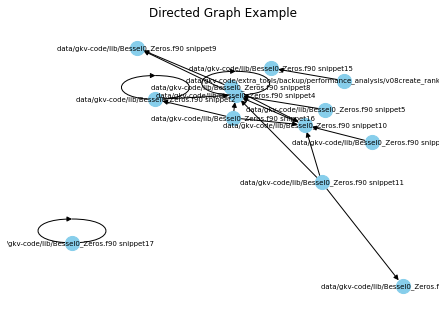

<Figure size 2160x1728 with 0 Axes>

In [21]:
import json
import os

file_path_json = "summary/" + database_name + ".json"
with open(file_path_json) as json_file:
    summary = json.load(json_file)
file_path_json = "file_paths/" + database_name + ".json"
with open(file_path_json) as json_file:
    file_paths = json.load(json_file)
file_path_json = "defs/" + database_name + ".json"
with open(file_path_json) as json_file:
    defs = json.load(json_file)[-batch_size:]
file_path_json = "calls/" + database_name + ".json"
with open(file_path_json) as json_file:
    calls = json.load(json_file)[-batch_size:]


snippet_names=[]
pre_file_path = ""
overlap_num = 1
for i in range(len(file_paths)):
    if pre_file_path == file_paths[i]:
        overlap_num += 1
    else:
        overlap_num = 1
        pre_file_path = file_paths[i]
        
    snippet_names.append(file_paths[i] + " snippet" + str(overlap_num))


defs_name2id = {}
for i in range(len(defs)):
    try:
        for key in defs[i]:
            defs_name2id[key] = i
    except:
        pass


calls_id2names = {}
for i in range(len(calls)):
    try:
        keys = []
        for key in calls[i]:
            keys.append(key)
            
        calls_id2names[i] = keys
    except:
        pass


edges = []
for id in calls_id2names:
    for key in calls_id2names[id]:
        if key in defs_name2id:
            edges.append((snippet_names[id], snippet_names[defs_name2id[key]]))
            

import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges (directed from first to second node)
#edges = [("A", "B"), ("B", "C"), ("A", "C"), ("C", "D")]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, edge_color='k', linewidths=1, font_size=7, arrows=True)
plt.title('Directed Graph Example')
plt.figure(figsize=(30, 24))
plt.show()

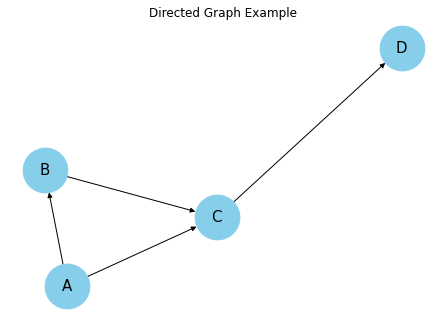

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges (directed from first to second node)
edges = [("A", "B"), ("B", "C"), ("A", "C"), ("C", "D")]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='k', linewidths=1, font_size=15, arrows=True)
plt.title('Directed Graph Example')
plt.show()


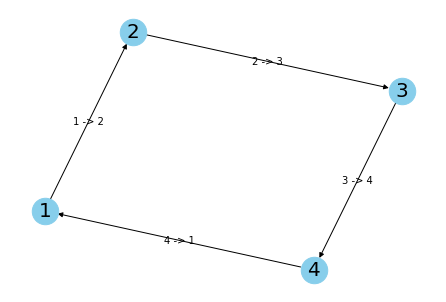

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from([1, 2, 3, 4])

# Add edges
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])

# Set a random seed (optional but recommended for reproducibility)
random_seed = 42

# Draw the graph
pos = nx.spring_layout(G, seed=random_seed)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=20, arrows=True)

# Add text along the edges
for u, v in G.edges():
    edge_label = f"{u} -> {v}"  # Create a label for the edge
    x = (pos[u][0] + pos[v][0]) / 2  # Compute x-coordinate for the label
    y = (pos[u][1] + pos[v][1]) / 2  # Compute y-coordinate for the label
    plt.text(x, y, edge_label, horizontalalignment='center', verticalalignment='center')

# Show the plot
plt.show()


## Embedding

### chunks

In [1]:
database_name = "transformers"
embed_model_id = "mixedbread-ai/mxbai-embed-large-v1"
batch_size = 20000

from sentence_transformers import SentenceTransformer, util
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
embed_model = SentenceTransformer(embed_model_id).to(device)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/113k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [2]:
import os
import json

json_file_path = f"processed/{database_name}/chunks.json"
with open(json_file_path, 'r') as json_file:
    chunks = json.load(json_file)

def save_outputs(text_list, batch_size, file_path):
    num_batch = 0
    
    # Get model outputs
    with torch.no_grad():
        outputs = torch.tensor(embed_model.encode(text_list))
        #outputs = outputs.reshape(num_rows, max_length, -1)
        print("outputs.shape : ", outputs.shape)
        torch.save(outputs.detach().cpu(), file_path)

    """ when total data size exceeds the batch_size
    for i in range(0, len(text_list), batch_size):
        batch_text_list = text_list[i:i+batch_size]
        num_rows = len(batch_text_list)
        #inputs = tokenizer(batch_text_series, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
        #inputs.to(device)
        
        # Get model outputs
        with torch.no_grad():
            outputs = torch.tensor(model.encode(batch_text_list))
            #outputs = outputs.reshape(num_rows, max_length, -1)
            print("outputs.shape : ", outputs.shape)
            torch.save(outputs.detach().cpu(), file_path+str(num_batch)+".pt")
            num_batch += 1

            del outputs
        
        print(100*(i+batch_size)/len(batch_text_list), "% finished")
    """

save_outputs(chunks, batch_size, f"processed/{database_name}/chunk_embs.pt")


outputs.shape :  torch.Size([1444, 1024])


### summary

In [5]:
database_name = "gkv-code"
embed_model_id = "mixedbread-ai/mxbai-embed-large-v1"
batch_size = 20000

from sentence_transformers import SentenceTransformer, util
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
embed_model = SentenceTransformer(embed_model_id).to(device)


In [6]:
import os
import json

json_file_path = f"processed/{database_name}/summary.json"
with open(json_file_path, 'r') as json_file:
    summary = json.load(json_file)

def save_outputs(text_list, batch_size, file_path):
    num_batch = 0
    
    # Get model outputs
    with torch.no_grad():
        outputs = torch.tensor(embed_model.encode(text_list))
        #outputs = outputs.reshape(num_rows, max_length, -1)
        print("outputs.shape : ", outputs.shape)
        torch.save(outputs.detach().cpu(), file_path)

    """ when total data size exceeds the batch_size
    for i in range(0, len(text_list), batch_size):
        batch_text_list = text_list[i:i+batch_size]
        num_rows = len(batch_text_list)
        #inputs = tokenizer(batch_text_series, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
        #inputs.to(device)
        
        # Get model outputs
        with torch.no_grad():
            outputs = torch.tensor(model.encode(batch_text_list))
            #outputs = outputs.reshape(num_rows, max_length, -1)
            print("outputs.shape : ", outputs.shape)
            torch.save(outputs.detach().cpu(), file_path+str(num_batch)+".pt")
            num_batch += 1

            del outputs
        
        print(100*(i+batch_size)/len(batch_text_list), "% finished")
    """

save_outputs(summary, batch_size, f"processed/{database_name}/summary_embs.pt")


outputs.shape :  torch.Size([928, 1024])


## Template Chat

In [3]:
database_name = "transformers"
max_more = 5
max_dispose = 10

In [4]:
# model load
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer

device = "cuda" if torch.cuda.is_available else "cpu"
emb_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1").to(device)

"""
# Model load for japanese
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

assert transformers.__version__ >= "4.34.1"

model = AutoModelForCausalLM.from_pretrained("cyberagent/calm2-7b-chat", device_map="auto", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained("cyberagent/calm2-7b-chat")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
"""

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id, 
    padding_side="left",
    add_eos_token=False,
    add_bos_token=False,)
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

model = AutoModelForCausalLM.from_pretrained(model_id).to(device)


# for json enforcer
from pydantic import BaseModel
from lmformatenforcer import JsonSchemaParser
from lmformatenforcer.integrations.transformers import build_transformers_prefix_allowed_tokens_fn
from transformers import pipeline

hf_pipeline = pipeline('text-generation', model=model, tokenizer = tokenizer, device = 0)




modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/113k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [6]:
import json
import os

device = "cuda" if torch.cuda.is_available else "cpu"

class FRAG:
    def __init__(self, database_name, max_more, max_dispose):
        # path for making function-explanation
        self.path_call = f"processed/{database_name}/calls.json"
        self.path_def = f"processed/{database_name}/defs.json"
        self.file_paths = f"processed/{database_name}/file_paths.json"

        self.max_more = max_more
        self.max_dispose = max_dispose

    
    def get_answer(self, original_question):
        generate = False
        next_question = original_question
        self.code_mem_list = []
        self.keep_id_list = []
        self.dispose_list = []

        i = 0
        while generate == False and i < self.max_more:
            j=0
            i += 1
            keep = False
            
            while keep == False and j < self.max_dispose:
                j += 1
                infs, id = self.get_infs(next_question, self.dispose_list, self.keep_id_list)
                keep, thought = self.LLM1(next_question, infs[0], id)
                
                if keep:
                    self.keep_id_list.append(id)
                    break
                else:
                    self.dispose_list.append(id)
            
            generate, next_question, thought = self.LLM2(original_question, next_question, self.code_mem_list, self.keep_id_list)
            
            code_mem, relation = self.SUMLLM(original_question, next_question, infs[0], id)
            
            self.code_mem_list.append(code_mem)

        answer = self.GENELLM(original_question, self.code_mem_list, self.keep_id_list)

        return answer


    
    def LLM1(self, question, code_inf, code_id):
        func_des = self.get_func_description(code_id)

        # for restricting answer to be json 
        class LLM1Format(BaseModel):
            thought: str
            keep: bool

        parser = JsonSchemaParser(LLM1Format.schema())
        prefix_function = build_transformers_prefix_allowed_tokens_fn(hf_pipeline.tokenizer, parser)

        prompt = f"""
[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {{"keep":true}} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {{"keep":false}} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: {question}

<<SYS>>
Function description:
{func_des}

Code from system:
```
{code_inf}
```

Firstly, you need to share your opinion about the reason for your decision, then you need to share your decision. Use the json format below:
{{
    "thought": (Explain whether the given code is necessary to answer the user's question, and how it relates, even if partially.),
    "keep": (Choose from "true" or "false".)
}}
<</SYS>>
[/INST]"""
        
        output = self.get_output(prompt, max_new_tokens = 1000, prefix_function = prefix_function)
        processed, json_mode = self.text2json(output)

        if json_mode:
            keep = processed["keep"]
            thought = processed["thought"]
        else:
            keep = True if "True" in processed else False
            thought = processed
            
        return keep, thought
        


    def LLM2(self, original_question, next_question, code_mem_list, keep_id_list):
        combined_code = self.combine_codes(code_mem_list,keep_id_list)

        # for restricting answer to be json 
        class LLM2Format(BaseModel):
            thought: str
            generate: bool
            next_question: str

        parser = JsonSchemaParser(LLM2Format.schema())
        prefix_function = build_transformers_prefix_allowed_tokens_fn(hf_pipeline.tokenizer, parser)

        prompt = f"""[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {{"generate":false}} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {{"generate":true}} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: {original_question}
Last search question:{next_question}

<<SYS>>
#Pieces of code from system:
{combined_code}

Firstly, you need to share your opinion about that the provided code is sufficient or insufficient, then you need to share your decision. Additionally, you must formulate a follow-up question to collect the missing information necessary to complete the code. Use the json format below:
{{
    "thought": (Explain why the provided code is sufficient or insufficient),
    "generate": (Choose from 'true' or 'false'),
    "next_question": (Formulate a question to help gather the missing or additional code required)
}}
<</SYS>>
[/INST]"""
        
        output = self.get_output(prompt, max_new_tokens = 3500, prefix_function = prefix_function)
        processed, json_mode = self.text2json(output)

        if json_mode:
            generate = processed["generate"]
            next_question = processed["next_question"]
            thought = processed["thought"]
        else:
            generate = True if "True" in processed else False
            next_question = processed
            thought = processed
            
        return generate, next_question, thought



    def SUMLLM(self, original_question, next_question, code_inf, id):
        func_des = self.get_func_description(id)
        add_code, folder_des = self.get_address_folder(id)

        # for restricting answer to be json 
        class SUMLLMFormat(BaseModel):
            code: str
            relation: str

        parser = JsonSchemaParser(SUMLLMFormat.schema())
        prefix_function = build_transformers_prefix_allowed_tokens_fn(hf_pipeline.tokenizer, parser)
        
        prompt = f"""[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:
{original_question}

<<SYS>>
Question for Searching the code below:{next_question}
#Code from system:

##Code Overview Set
{add_code}

{folder_des}

{func_des}

Code:
```
{code_inf}
```

You are required to extract the significant sections from the provided code that are essential for answering the user's question and return it in json text. Highlight these sections and explain their relevance to the question without altering the original code format or content. Please follow the json format below:

{{
    "thought": (Quick explanation of the answer you will give in the folloing.),
    "code": (The critical parts of the code necessary to answer the user's question. Do not modify or editorialize the code. If no sections of the code are critical, you should explicitly output "Nothing".),
    "relation": (Tell me relation between the code and Users question. If no sections of the code are related, you should explicitly output "Nothing")
}}

<</SYS>>
[/INST]"""
        
        output = self.get_output(prompt, max_new_tokens = 2500, prefix_function = prefix_function)
        processed, json_mode = self.text2json(output)

        if json_mode:
            code = processed["code"]
            relation = processed["relation"]
        else:
            code = processed
            relation = processed
            
        return code, relation


    
    def GENELLM(self, original_question, code_mem_list, keep_id_list):
        combined_code = self.combine_codes(code_mem_list,keep_id_list)
        
        prompt = f"""[INST]<<SYS>>
You are an excellent programmer and are adept at explaining code. You will be provided with one or more pieces of code along with corresponding questions from systems. The provided code is selected from a larger codebase specifically to enable you to answer these questions. Your task is to answer the user’s questions as thoroughly and clearly as possible, demonstrating your understanding and ability to communicate key coding concepts.

<</SYS>>

User question:
{original_question}

<<SYS>>
#Pieces of code from system:

{combined_code}
<</SYS>>[/INST]"""
        
        return self.get_output(prompt, max_new_tokens = 2500)

    
    def get_output(self, prompt, max_new_tokens = 1000, prefix_function = None):
        print()
        print("=== input ===")
        print(prompt)
        
        if prefix_function == None:
            print()
            print("=== normal output ===")
            input_ids = tokenizer(prompt, return_tensors="pt").to(device)
            output_ids = model.generate(
                **input_ids,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.8,
                streamer=streamer
            )
            output = tokenizer.decode(output_ids[0][len(input_ids[0]):], skip_special_tokens = True)
            return output

        else:
            print()
            print("=== json output ===")

            #hf_pipeline.max_length = max_new_tokens
            output_dict = hf_pipeline(prompt, max_new_tokens = max_new_tokens, prefix_allowed_tokens_fn = prefix_function)
            print(output_dict[0]['generated_text'][len(prompt):])
            
            return output_dict[0]['generated_text'][len(prompt):]
        

    def text2json(self, text):
        try:
            output = json.loads(text)
            return output, True
    
        except:
            print()
            print("Failed to get json type object")
            return text, False

    
    def get_infs(self, question, disposed_id_list, keep_id_list):
        # 問題文に基づいて検索する
        q_embs = torch.tensor(emb_model.encode(question)).to(device)
        inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)
        
        with open(f"processed/{database_name}/chunks.json") as json_file:
            chunks = json.load(json_file)
    
        relevance = torch.matmul(q_embs, inf_embs.T) 
        
        # Top-3 のIDを取得
        values, inf_ids = torch.topk(relevance, k=3, dim=0)  # dim=1 で行ごとのTop-Kを取得
        
        infs = []
        selected_id = None
        for id in inf_ids:
            if id.item() not in disposed_id_list:
                if id.item() not in keep_id_list:
                    selected_id = id.item()
                    infs.append(chunks[selected_id])
                    break  # 最初に見つかった適切なIDで終了
    
        if selected_id == None:
            values, inf_ids = torch.topk(relevance, k=relevance.shape[0], dim=0)
            for id in inf_ids:
                if id.item() not in disposed_id_list:
                    if id.item() not in keep_id_list:
                        selected_id = id.item()
                        infs.append(chunks[selected_id])
                        break  # 最初に見つかった適切なIDで終了
                
        return infs, selected_id
    
    
    
    def get_func_description(self, id):
        #initialize func_list
        func_list = []
        func_set = set()
        # open calls folder
        with open(self.path_call, 'r') as file:
            data = json.load(file)
            functions = data[id]
        for key1, value1 in functions.items():
            # open defs folder
            with open(self.path_def, 'r') as file:
                 defs_data = json.load(file)
            
            for def_item in defs_data:
                for key2, value2 in def_item.items():
                    if key2 == key1:
                        if key2 not in func_set:
                            func_set.add(key2)
                            func_list.append(f"{key2}:{value2}")
    
        if not func_list:
            return ""
        
        formatted_descriptions = [
            f"- {desc.split(':')[0]}: {desc.split(':')[1].strip()}."
            for desc in func_list
        ]
    
        # 最終的な説明文を生成
        description_of_functions = "Description of the functions used in the code below:\n" + "\n".join(formatted_descriptions)
        
        return description_of_functions
    
    
    
    def get_address_folder(self, id):
        # get file_paths from id
        with open(self.file_paths, 'r') as file:
            data = json.load(file)
            file_path = data[id]
        f_name_list, f_summary_list = self.get_path_summaries(file_path, database_name)
        address_code = self.generate_tree_structure(f_name_list)
        formatted_descripitions = self.format_descriptions(f_name_list, f_summary_list)
        return address_code, formatted_descripitions
    
    
    
    def get_path_summaries(self, file_path, dataset_name):
        file_path_json = f"processed/{database_name}/f_summary.json"
        with open(file_path_json) as json_file:
            f_summary = json.load(json_file)
    
        f_name_list = []
        f_summary_list = []
        while "/" in file_path: # not run when path == data where summary of dataset_name folder is already added to the list
            f_name_list.insert(0, os.path.basename(file_path))
            f_summary_list.insert(0, f_summary[file_path])
            file_path = os.path.dirname(file_path)
            
        return f_name_list, f_summary_list
    
    
    
    def generate_tree_structure(self, folders_files):
        # 基本のパスを設定
        base = "The address of code below:{\n"
        # 各フォルダやファイルに対してツリーノードを追加
        indent = ""
        for i, item in enumerate(folders_files):
            if i < len(folders_files) - 1:  # 最後の要素でない場合
                base += f"{indent}|─ {item}/\n"
                indent += "|   "  # インデントを追加
            else:  # 最後の要素の場合
                base += f"{indent}|─ {item}/\n"
        base += "}"
        return base

    
    # フォルダとファイルの説明をフォーマットする関数
    def format_descriptions(self, f_name_list, f_summary_list):
        formatted_text = "Folder and file descriptions:\n"
        for name, desc in zip(f_name_list, f_summary_list):
            formatted_text += f"  - name: {name}\n    description: {desc}\n"
        return formatted_text
        
        
    
    def get_prompt(self, q, inf_list):
        prompt = q + "\nCode:"
        for inf in inf_list:
            prompt += "\n```" + inf + "```"
            
        return prompt
    
    def combine_codes(self, code_mem_list,keep_id_list):
        combined_code = ""
        for id, code in zip(keep_id_list, code_mem_list):
            set = "##Code Overview Set"
            add_code, folder_des = self.get_address_folder(id)
            func_des = self.get_func_description(id)
            set += f"\n{add_code}\n\n{folder_des}\n\n{func_des}\n\n```\n{code}\n```\n\n"
            combined_code += set
        return combined_code

    def get_new_question(self, output):
        # 'Next question:' または 'Next question :' のインデックスを取得
        next_question_index = output.find('Next question:')
        if next_question_index != -1:
            # 'Next question:'の後の空白をスキップ
            question_start_index = next_question_index + len('Next question:')
            while output[question_start_index] == ' ':
                question_start_index += 1
            
            # 質問文を取得し、不要なタグを削除
            question_end_index = output.find('</s>', question_start_index)
            if question_end_index == -1:
                question_end_index = None  # タグがない場合は文字列の最後までが質問
            question = output[question_start_index:question_end_index].strip()
        else:
            question = "Next question not found in input"
        
        return question


# jsonでerrorが出た時に、もっといい方法があると思う（LLMのoutputをrelationなどにわけず柔軟に対応できたらもっといい）

In [8]:
original_question = """
where is a folder to define input of the pretrained_model?
"""
frag = FRAG(database_name, max_more, max_dispose)
frag.get_answer(original_question)

# この質問に関しては検索エンジンの性能とenvironmentの説明をもっと詳しくしていくだけ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
where is a folder to define input of the pretrained_model?


<<SYS>>
Function description:


Code from system:
```

class FlaxPreTrainedModel(PushToHubMixin, FlaxGenerationMixin):
    r"""
    Base class for all models.

    [`Fla

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
where is a folder to define input of the pretrained_model?


<<SYS>>
Function description:


Code from system:
```


    @classmethod
    def from_pretrained(
        cls,
        pretrained_model_name_or_path: Optional[Union[str,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
where is a folder to define input of the pretrained_model?

Last search question:
where is a folder to define input of the pretrained_model?


<<SYS>>
#Pieces of code from system:


Firstly, you need to share your opinion about that the provided code is sufficient or insufficient, then you need to share your decision. Additionally, you must formulate a follo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

where is a folder to define input of the pretrained_model?


<<SYS>>
Question for Searching the code below:Could you please specify the location of the input folder for the pretrained model in the code?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |  

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model in the code?

<<SYS>>
Function description:
Description of the functions used in the code below:
- raise EnvironmentError: Raises an environment err

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
where is a folder to define input of the pretrained_model?

Last search question:Could you please specify the location of the input folder for the pretrained model in the code?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   |   |   |─ mod

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

where is a folder to define input of the pretrained_model?


<<SYS>>
Question for Searching the code below:Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:
Description of the functions used in the code below:
- has_file:

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

    dataloader_prefetch_factor: Optiona

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

        Parameters:
            pretrai

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
where is a folder to define input of the pretrained_model?

Last search question:Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |  

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

where is a folder to define input of the pretrained_model?


<<SYS>>
Question for Searching the code below:Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```


    @property
    def dummy_inputs(sel

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:
Description of the functions used in the code below:
- Generatio

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
where is a folder to define input of the pretrained_model?

Last search question:Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |  

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

where is a folder to define input of the pretrained_model?


<<SYS>>
Question for Searching the code below:Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:
Description of the functions used in the code below:
- DataColla

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:
Description of the functions used in the code below:
- cls.get_f

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

           "GroundingDinoModel",
      

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:
Description of the functions used in the code below:
- open: Bui

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

        save_steps (`int`, *optional*, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```


        # Update the references
      

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

	def _v2_get_resized_embeddings(
      

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

		if ignore_mismatched_sizes:
         

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

class Seq2SeqTrainer(Trainer):
    def 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
Function description:


Code from system:
```

   _import_structure["models.electra"].

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
where is a folder to define input of the pretrained_model?

Last search question:Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |  

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

where is a folder to define input of the pretrained_model?


<<SYS>>
Question for Searching the code below:Could you please specify the location of the input folder for the pretrained model within the provided folder structure or in the code?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 {
    "code": "Nothing",
    "relation": "The user's question asks about the location of the input folder for a pretrained model, but the provided code does not contain any information about the input folder's location or structure. It only imports various models and their pretrained versions from Hugging Face Transformers library."
}

=== input ===
[INST]<<SYS>>
You are an excellent programmer and are adept at explaining code. You will be provided with one or more pieces of code along with corresponding questions from systems. The provided code is selected from a larger codebase specifically to enable you to answer these questions. Your task is to answer the user’s questions as thoroughly and clearly as possible, demonstrating your understanding and ability to communicate key coding concepts.

<</SYS>>

User question:

where is a folder to define input of the pretrained_model?


<<SYS>>
#Pieces of code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ tran

'The pretrained model\'s input definition is not directly related to the provided code snippets. However, based on the given context, the input for a pretrained model using Hugging Face\'s Transformers library is typically in the form of input IDs, input encodings, or input features, which should be provided when calling the model\'s `generate()` or `predict()` functions.\n\nThe input data must be preprocessed and tokenized before being passed to the model. Preprocessing and tokenization steps often involve loading the preprocessing tokenizer, encoding the input text, and padding or truncating the input sequences to a required length. This process varies depending on the specific NLP task and the preprocessing requirements of your pretrained model.\n\nHere\'s an example of how you might prepare input data for a BERT model using Hugging Face\'s Transformers library:\n\n```python\nfrom transformers import BertTokenizer, BertForSequenceClassification\n\n# Load your pretrained model and to

In [7]:
original_question = """
what's the difference between mistral and mixtral?
"""
frag = FRAG(database_name, max_more, max_dispose)
frag.get_answer(original_question)

#

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:


Code from system:
```
# coding=utf-8
# Copyright 2024 Mistral AI and the HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apach

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:


Code from system:
```


@add_start_docstrings(
    "The bare Mistral Model outputting raw hidden-states without any specific head on top.",
    M

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:


Code from system:
```


# Copied from transformers.models.llama.modeling_flax_llama.FlaxLlamaRMSNorm with Llama->Mistral
class FlaxMistralRMSNorm

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:
Description of the functions used in the code below:
- super: calls a method from a parent class.
- shape_list: A function that returns the shape o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:


Code from system:
```


@add_start_docstrings(
    """
    The Mistral Model transformer with a sequence classification head on top (linear layer

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:
Description of the functions used in the code below:
- FlaxMistralRMSNorm: Flax normalization function for Mistral model.
- FlaxMistralAttention: F

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:
Description of the functions used in the code below:
- TFMistralRMSNorm: Implements the RMSNorm layer used in the T5 model.
- _make_causal_mask: A 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:
Description of the functions used in the code below:
- PretrainedConfig: A dataclass representing the configuration of a pretrained model for quant

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:


Code from system:
```


# Copied from transformers.models.gpt_neo.modeling_flax_gpt_neo.FlaxGPTNeoPreTrainedModel with GPTNeo->Mistral, GPT_NEO->

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?


<<SYS>>
Function description:


Code from system:
```
# coding=utf-8
# Copyright 2024 Mistral AI and the HuggingFace Inc. team. All rights reserved.
#
# This code is based on El

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?

Last search question:
what's the difference between mistral and mixtral?


<<SYS>>
#Pieces of code from system:


Firstly, you need to share your opinion about that the provided code is sufficient or insufficient, then you need to share your decision. Additionally, you must formulate a follow-up question to

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

what's the difference between mistral and mixtral?


<<SYS>>
Question for Searching the code below:Can you please provide more context about Mistral and Mixtral, such as what they represent or what they are used for?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Can you please provide more context about Mistral and Mixtral, such as what they represent or what they are used for?

<<SYS>>
Function description:


Code from system:
```


class MistralMLP(nn.Module):
    def __init__(self, conf

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Can you please provide more context about Mistral and Mixtral, such as what they represent or what they are used for?

<<SYS>>
Function description:


Code from system:
```


# Copied from transformers.models.llama.modeling_llama.L

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?

Last search question:Can you please provide more context about Mistral and Mixtral, such as what they represent or what they are used for?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

what's the difference between mistral and mixtral?


<<SYS>>
Question for Searching the code below:What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transforme

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
Function description:


Code from system:
```


# Copied from transformers.models.gptj.mode

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
Function description:


Code from system:
```


TFGreedySearchOutput = Union[TFGreedySearch

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
Function description:
Description of the functions used in the code below:
- super: calls a

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
Function description:


Code from system:
```

   "models.musicgen": [
        "MusicgenCon

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
Function description:


Code from system:
```


# Copied from transformers.models.llama.mod

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?

Last search question:What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transform

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

what's the difference between mistral and mixtral?


<<SYS>>
Question for Searching the code below:What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transforme

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
Function description:


Code from system:
```


@add_start_docstrings(
    """
    The Mist

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?

Last search question:What are the key differences between the Mistral and Mixtral language models in terms of architecture, use cases, and performance?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transform

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

what's the difference between mistral and mixtral?


<<SYS>>
Question for Searching the code below:What are the main architectural differences between Mistral and Mixtral language models? In what scenarios would one be preferred over the other? What are the performance benchmarks for Mistral and Mixtral in terms of through

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the main architectural differences between Mistral and Mixtral language models? In what scenarios would one be preferred over the other? What are the performance benchmarks for Mistral and Mixtral in terms of throughput, l

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the main architectural differences between Mistral and Mixtral language models? In what scenarios would one be preferred over the other? What are the performance benchmarks for Mistral and Mixtral in terms of throughput, l

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: What are the main architectural differences between Mistral and Mixtral language models? In what scenarios would one be preferred over the other? What are the performance benchmarks for Mistral and Mixtral in terms of throughput, l

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
what's the difference between mistral and mixtral?

Last search question:What are the main architectural differences between Mistral and Mixtral language models? In what scenarios would one be preferred over the other? What are the performance benchmarks for Mistral and Mixtral in terms of throughput, latency, and model size?

<<SYS>>
#Pieces of code from sy

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

what's the difference between mistral and mixtral?


<<SYS>>
Question for Searching the code below:Where in the codebase can I find the Mixtral model implementation for comparison with Mistral?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 {
    "code": "",
    "relation": "Nothing, the user's question is about the difference between Mistral and Mixtral, which is not related to the provided code."
}

=== input ===
[INST]<<SYS>>
You are an excellent programmer and are adept at explaining code. You will be provided with one or more pieces of code along with corresponding questions from systems. The provided code is selected from a larger codebase specifically to enable you to answer these questions. Your task is to answer the user’s questions as thoroughly and clearly as possible, demonstrating your understanding and ability to communicate key coding concepts.

<</SYS>>

User question:

what's the difference between mistral and mixtral?


<<SYS>>
#Pieces of code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   |   |   |─ models/
|   |   |   |   |   |─ mistral/
|   |   |   |   |   |   |─ modeling_mistral.py/
}

Folder and file d

"Based on the provided code and context, there is no clear answer to the user's question about the difference between Mistral and Mixtral as the code only includes the Mistral implementation. A thorough comparison between Mistral and Mixtral requires access to both implementations. In the absence of Mixtral's implementation, the code's relevance to the question is minimal, but it might still be useful for a more comprehensive understanding of the Mistral model.\n\nThe provided code snippet is a part of the Mistral model implementation for the token classification task. The MistralForTokenClassification class inherits from the MistralPreTrainedModel class and contains a linear layer on top of the hidden states output for the classification head. The class also includes methods for forward propagation and setting input embeddings.\n\nTo answer the user's question, one would need to compare the Mistral and Mixtral implementations, which might be found in different parts of the codebase or

In [8]:
original_question = """
Explain the structure of Trainer class.
"""
frag = FRAG(database_name, max_more, max_dispose)
frag.get_answer(original_question)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
Explain the structure of Trainer class.


<<SYS>>
Function description:


Code from system:
```


    Important attributes:

        - **model** -- Always points to the core model. If using a transformers model, it will be a [`Pre

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
Explain the structure of Trainer class.

Last search question:
Explain the structure of Trainer class.


<<SYS>>
#Pieces of code from system:


Firstly, you need to share your opinion about that the provided code is sufficient or insufficient, then you need to share your decision. Additionally, you must formulate a follow-up question to collect the missing i

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

Explain the structure of Trainer class.


<<SYS>>
Question for Searching the code below:Could you please share the definition of the Trainer class?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   |   |   |─ trainer.py/
}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the definition of the Trainer class?

<<SYS>>
Function description:


Code from system:
```



		deepspeed (`str` or `dict`, *optional*):
            Use [Deepspeed](https://github.com/microsoft/deepspeed). T

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the definition of the Trainer class?

<<SYS>>
Function description:
Description of the functions used in the code below:
- TrainingSummary.from_keras: A static method for creating a TrainingSummary object fro

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the definition of the Trainer class?

<<SYS>>
Function description:


Code from system:
```

	def get_optimizer_group(self, param: Optional[Union[str, torch.nn.parameter.Parameter]] = None):
        """
     

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the definition of the Trainer class?

<<SYS>>
Function description:


Code from system:
```

        save_steps (`int`, *optional*, defaults to 500):
            Number of updates steps before two checkpoint 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the definition of the Trainer class?

<<SYS>>
Function description:


Code from system:
```


class TrainerCallback:
    # no-format
    """
    A for objects that will inspect the state of the training loop 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the definition of the Trainer class?

<<SYS>>
Function description:


Code from system:
```

    hub_strategy: Union[HubStrategy, str] = field(
        default="every_save",
       metadata={"help": "The hub 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
Explain the structure of Trainer class.

Last search question:Could you please share the definition of the Trainer class?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   |   |   |─ trainer.py/
}

Folder and file descriptions:
  - name: dat

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

Explain the structure of Trainer class.


<<SYS>>
Question for Searching the code below:Could you please share the implementation of the Trainer class from the trainer.py file?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the implementation of the Trainer class from the trainer.py file?

<<SYS>>
Function description:


Code from system:
```
# coding=utf-8
# Copyright 2020-present the HuggingFace Inc. team.
#
# Licensed under t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the implementation of the Trainer class from the trainer.py file?

<<SYS>>
Function description:


Code from system:
```



            <Tip>

            When set to `True`, the parameters `save_strategy` ne

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the implementation of the Trainer class from the trainer.py file?

<<SYS>>
Function description:


Code from system:
```


    epoch: Optional[float] = None
    global_step: int = 0
    max_steps: int = 0
   

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
Explain the structure of Trainer class.

Last search question:Could you please share the implementation of the Trainer class from the trainer.py file?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   |   |   |─ trainer.py/
}

Folder and fil

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

Explain the structure of Trainer class.


<<SYS>>
Question for Searching the code below:Could you please share the implementation of the Trainer class from the Hugging Face Transformers library?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```
# coding=utf-8
# Copyright 2020-present the HuggingFace Inc. team.
#


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```



        eval_accumulation_steps (`int`, *optional*):
            N

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
Explain the structure of Trainer class.

Last search question:Could you please share the implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   |   |   |─ trainer.py/

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

Explain the structure of Trainer class.


<<SYS>>
Question for Searching the code below:Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   | 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```

       batch_eval_metrics (`Optional[bool]`, defaults to `F

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```



        hub_token (`str`, *optional*):
            The to

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```


        bf16_full_eval (`bool`, *optional*, defaults to `F

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```

           The options should be separated by whitespaces.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```

   auto_find_batch_size: bool = field(
        default=Fals

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```



            This should not be activated when the differe

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:
Description of the functions used in the code below:
- torch.load: A PyTorch functio

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```

    "models.idefics2": ["Idefics2Config"],
    "models.imag

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:


Code from system:
```


class CallbackHandler(TrainerCallback):
    """Internal th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
Function description:
Description of the functions used in the code below:
- logger.warning: A logging fun

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
Explain the structure of Trainer class.

Last search question:Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?

<<SYS>>
#Pieces of code from system:
##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   |   |   |─ transformers/
|   |   |   |   |─ tr

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

Explain the structure of Trainer class.


<<SYS>>
Question for Searching the code below:Could you please share the complete implementation of the Trainer class from the Hugging Face Transformers library?
#Code from system:

##Code Overview Set
The address of code below:{
|─ data/
|   |─ transformers/
|   |   |─ src/
|   | 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 {
    "code": "[...]\ndef _hp_search_setup(self, trial: Union[\"optuna.Trial\", Dict[str, Any]]):\n\t# Code for handling hyperparameter search setup\n\ndef num_tokens(self, train_dl: DataLoader, max_steps: Optional[int] = None) -> int:\n\t# Helper function to get number of tokens in a DataLoader\n",
    "relation": "The provided code includes the definition of the Trainer class from the Hugging Face Transformers library. The relevant sections for answering the user's question are the _hp_search_setup function and the num_tokens helper function. These functions are essential for understanding the structure of the Trainer class as they handle hyperparameter search setup and calculate the number of tokens in a DataLoader, respectively. The user's question asks for an explanation of the structure of the Trainer class, and these functions provide valuable insights into its functionality."
}

=== input ===
[INST]<<SYS>>
You are an excellent programmer and are adept at explaining code. You w

"The Trainer class in the Hugging Face Transformers library is designed to simplify the process of training and evaluating PyTorch models. It sets up and configures the training environment, including various arguments and optional features. Here's an overview of its structure and important attributes:\n\n1. Important attributes:\n   - **model**: Always points to the core model.\n   - **model_wrapped**: Always points to the most external model.\n   - **is_model_parallel**: Whether or not a model has been switched to a model parallel mode.\n   - **place_model_on_device**: Whether or not to automatically place the model on the device.\n   - **is_in_train**: Whether or not a model is currently running train.\n\nThe Trainer class also includes other features such as saving and loading checkpoints, handling data processing, and managing training loops. It is initialized with specific configurations for these tasks, which can be customized through various arguments.\n\nThe Trainer class also

In [9]:
original_question = """
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?
"""
frag = FRAG(database_name, max_more, max_dispose)
frag.get_answer(original_question)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?


<<SYS>>
Function description:


Code from system:
```


@add_start_docstrings(
 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?

Last search question:
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?


<<SYS>>
#Pieces of code from system:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?


<<SYS>>
Question for Searching the code below:Could you please share the Mistral modeling file'mistral_modeling.py' and specify the layers and their indices or names that you

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the Mistral modeling file'mistral_modeling.py' and specify the layers and their indices or names that you want to extract the outputs from?

<<SYS>>
Function description:


Code from system:
```
# coding=utf-

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the Mistral modeling file'mistral_modeling.py' and specify the layers and their indices or names that you want to extract the outputs from?

<<SYS>>
Function description:


Code from system:
```


# Copied fr

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the Mistral modeling file'mistral_modeling.py' and specify the layers and their indices or names that you want to extract the outputs from?

<<SYS>>
Function description:


Code from system:
```


@add_start_

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?

Last search question:Could you please share the Mistral modeling file'mistral_modeling.py' and specify the layers and their indices or names that you want to extract the outputs from?

<<SYS>>
#Pieces of code fr

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?


<<SYS>>
Question for Searching the code below:Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' file and specify the

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' file and specify the layers and their indices or names that you want to extract the outputs from?

<<SYS>>
Function descrip

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' file and specify the layers and their indices or names that you want to extract the outputs from?

<<SYS>>
Function descrip

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' file and specify the layers and their indices or names that you want to extract the outputs from?

<<SYS>>
Function descrip

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?

Last search question:Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' file and specify the layers and their indices or names that you want to extract th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?


<<SYS>>
Question for Searching the code below:Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' or'modeling_mistral.

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' or'modeling_mistral.py' file and specify the layers and their indices or names that you want to extract the outputs from?



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?

Last search question:Could you please share the specific implementation of the Mistral Transformer model in'mistral_modeling.py' or'modeling_mistral.py' file and specify the layers and their indices or names tha

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?


<<SYS>>
Question for Searching the code below:Could you please share the specific parts of the'mistral_modeling.py' file related to the Mistral Transformer model architecture

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please share the specific parts of the'mistral_modeling.py' file related to the Mistral Transformer model architecture and the forward pass function, along with the exact layers and their indices or names that you want to

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?

Last search question:Could you please share the specific parts of the'mistral_modeling.py' file related to the Mistral Transformer model architecture and the forward pass function, along with the exact layers an

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna modify mistral_modeling.py file so that I can designate layers of hidden state and only those outputs are returned. How to modify the code?


<<SYS>>
Question for Searching the code below:Could you please share the specific parts of the'mistral_modeling.py' file related to the Mistral Transformer model architecture

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 {
    "code": "[...]\nclass TFMistralForSequenceClassification(TFMistralPreTrainedModel, TFSequenceClassificationLoss):\n\n    def __init__(self, config, *inputs, **kwargs):\n        super().__init__(config, *inputs, **kwargs)\n        self.num_labels = config.num_labels\n        self.model = TFMistralMainLayer(config, name=\"model\")\n        self.score = keras.layers.Dense(\n            self.num_labels,\n            use_bias=False,\n            kernel_initializer=get_initializer(config.initializer_range),\n            name=\"score\",\n        )\n        self.config = config\n\n    [...] \n\n    @unpack_inputs\n    @add_start_docstrings_to_model_forward(MISTRAL_INPUTS_DOCSTRING.format(\"batch_size, sequence_length\"))\n    def call(self, input_ids: tf.Tensor = None, attention_mask: Optional[tf.Tensor] = None, position_ids: Optional[tf.Tensor] = None, past_key_values: Optional[List[tf.Tensor]] = None, inputs_embeds: Optional[tf.Tensor] = None, labels: Optional[tf.Tensor] = None, use_c

'To modify the `mistral_modeling.py` file for designing and returning only specified layers of hidden states, you can create a new class derived from `TFMistralPreTrainedModel` and override the `call` method to return the desired hidden states. Here\'s an example:\n\n```python\nimport tensorflow as tf\nfrom typing import List, Optional\n\nclass CustomTFMistralForHiddenStates(TFMistralPreTrainedModel):\n    def __init__(self, config, hidden_state_layers: List[int], *inputs, **kwargs):\n        super().__init__(config, *inputs, **kwargs)\n        self.hidden_state_layers = hidden_state_layers\n        self.model = TFMistralMainLayer(config, name="model")\n        self.config = config\n\n    @unpack_inputs\n    @add_start_docstrings_to_model_forward(MISTRAL_INPUTS_DOCSTRING.format("batch_size, sequence_length"))\n    def call(self, input_ids: tf.Tensor = None, attention_mask: Optional[tf.Tensor] = None, position_ids: Optional[tf.Tensor] = None, past_key_values: Optional[List[tf.Tensor]] =

In [10]:
original_question = """
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted."""
frag = FRAG(database_name, max_more, max_dispose)
frag.get_answer(original_question)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:
Description of the functions used in the code below:
- warnings.warn: A

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```

add_special_tokens else 0)

        # Truncati

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```

def save_pretrained(
        self,
        sav

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```
# Copyright 2020 The HuggingFace Team. All righ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```

	def _encode_plus(
        self,
        text:

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```


def __init__(self, **kwargs):
        # Attri

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```



    @classmethod
    def register_for_auto_c

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:
Description of the functions used in the code below:
- copy_func: A fun

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```

	def call(self, inputs: tf.Tensor, mode: str =

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Function description:


Code from system:
```

        > Parameters that define the output va

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.
Last search question:
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
#Pieces of code from system:


Firstly, you need to share your opinion ab

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Question for Searching the code below:Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.
Last search question:Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Question for Searching the code below:Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.
Last search question:Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Question for Searching the code below:Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.
Last search question:Could you please specify which Transformer model and which layer you want to add the LeakyReLU activation function to? Also, could you please provide the code for implementing the LeakyReLU function in PyTorch o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Question for Searching the code below:Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===

[INST]<<SYS>>You are an excellent commander. Based on the code from system and the question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"keep":true} in json text if the code provided is related, even partially, to the user's question. This indicates that the code, while possibly incomplete or not entirely covering all aspects, still has relevance and may contain useful elements or logic that pertains to the question.
- Include {"keep":false} in json text if the code provided is completely unrelated to the user's question. This means the code does not contribute in any way to answering the question and should be disregarded.

<</SYS>>

User question: Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning fra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>You are an excellent commander. Based on the code from system and question provided by the user, you decide the next action and answer it in json text. Use the following criteria to make your decision:

- Include {"generate":false} in json text if the code is related but not comprehensive enough to answer the question. This means some elements are missing, which are necessary to complete the answer or to cover all aspects of the question.
- Include {"generate":true} in json text if the code provided fully satisfies the requirements to answer the user's question comprehensively.

<</SYS>>

User question: 
I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.
Last search question:Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== input ===
[INST]<<SYS>>
You are a skilled programmer proficient in explaining code in json text. Your primary task is to identify and extract the crucial parts of code based on the pairings of user-submitted questions and corresponding code snippets. While the code often relates to the users questions, not all parts may be necessary to answer these questions. Users are specifically interested in those portions of the code that are most relevant to their inquiries. Therefore, you must focus solely on extracting these pertinent sections without modifying or editorializing the code. If no relevant code sections are found, output "Nothing".
<</SYS>>

User question:

I wanna add LeakyReLU function into transformers source code. Tell me where to insert the function and the code to be inserted.

<<SYS>>
Question for Searching the code below:Which Transformer model and which layer do you want to add the LeakyReLU activation function to? Could you please provide the code for implementing t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 {
"code": "Nothing",
"relation": "The provided code does not contain any Transformer model or layer definition, nor does it include any LeakyReLU activation function implementation. Therefore, it cannot be directly related to the user's question about adding a LeakyReLU function to a specific Transformer model and layer in the source code. The code snippet provided is related to cache management for Transformer models, specifically handling key and value states for different layers. However, it does not contain the necessary information to answer the user's question."
}

=== input ===
[INST]<<SYS>>
You are an excellent programmer and are adept at explaining code. You will be provided with one or more pieces of code along with corresponding questions from systems. The provided code is selected from a larger codebase specifically to enable you to answer these questions. Your task is to answer the user’s questions as thoroughly and clearly as possible, demonstrating your understanding an

"The user wants to add a LeakyReLU function to the Transformers source code. However, the provided code does not contain the Transformers model or the specific layer where the user wants to add the LeakyReLU activation function. Therefore, no sections of the code are related to the user's question.\n\nTo answer the question, the user needs to specify which Transformer model and which layer they want to add the LeakyReLU activation function to. Additionally, they should provide the code for implementing the LeakyReLU function in PyTorch or TensorFlow, depending on the deep learning framework being used for the Transformers source code. Once this information is available, the relevant sections of the code can be extracted and the user's question can be answered.\n\nIn the absence of this information, the answer is 'Nothing'."

### Embedding Search Test

## Template Chat2 (Feedback system & vLLM)

In [1]:
import torch
import time
import json
import os, re


# This code comes from 'https://docs.vllm.ai/en/stable/getting_started/examples/offline_inference_distributed.html'
from typing import Any, Dict, List
import time
import numpy as np
import ray
from ray.data import from_items
from packaging.version import Version
from ray.util.scheduling_strategies import PlacementGroupSchedulingStrategy
from vllm import LLM, SamplingParams

assert Version(ray.__version__) >= Version("2.22.0"), "Ray version must be at least 2.22.0"

# Create a sampling params object.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=1000)

# Set tensor parallelism per instance.
tensor_parallel_size = 1

# Set number of instances. Each instance will use tensor_parallel_size GPUs.
num_instances = 1


# Create a class to do batch inference.
class LLMPredictor:
    def __init__(self):
        #model_path = "meta-llama/Llama-2-7b-chat-hf"
        #model_path = "openchat/openchat-3.5-0106"
        model_path = "Qwen/Qwen2-7B-Instruct"
        self.llm = LLM(model=model_path, tensor_parallel_size=tensor_parallel_size)

    def __call__(self, batch): #: Dict[str, np.ndarray]) -> Dict[str, list]:
        outputs = self.llm.generate(batch["prompt"], sampling_params)

        prompt: List[str] = []
        generated_text: List[str] = []
        for output in outputs:
            prompt.append(output.prompt)
            generated_text.append(' '.join([o.text for o in output.outputs]))

        return {"q_id": batch["q_id"], "inf_id": batch["inf_id"], "prompt": prompt, "generated_text": generated_text,}


# For tensor_parallel_size > 1, we need to create placement groups for vLLM
# to use. Every actor has to have its own placement group.
def scheduling_strategy_fn():
    # One bundle per tensor parallel worker
    pg = ray.util.placement_group(
        [{
            "GPU": 1,
            "CPU": 1
        }] * tensor_parallel_size,
        strategy="STRICT_PACK",
    )
    return dict(scheduling_strategy=PlacementGroupSchedulingStrategy(
        pg, placement_group_capture_child_tasks=True))


resources_kwarg: Dict[str, Any] = {}
if tensor_parallel_size == 1:
    # For tensor_parallel_size == 1, we simply set num_gpus=1.
    resources_kwarg["num_gpus"] = 1
else:
    # Otherwise, we have to set num_gpus=0 and provide
    # a function that will create a placement group for
    # each instance.
    resources_kwarg["num_gpus"] = 0
    resources_kwarg["ray_remote_args_fn"] = scheduling_strategy_fn

print("All Finished")

All Finished


In [29]:
import json
import os
import torch
from sentence_transformers import SentenceTransformer, util
device = "cuda" if torch.cuda.is_available else "cpu"
emb_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1").to(device)

class FRAG:
    def __init__(self, database_name, max_more, max_dispose, num_relevance, max_inf_num):
        # path for making function-explanation
        self.database_name = database_name
        
        self.max_more = max_more
        self.max_dispose = max_dispose
        self.num_relevance = num_relevance  # max number of chunks to extract

        self.max_inf_num = max_inf_num


    def get_answer(self, original_question):
        generate = False
        answer_prompt = None
        questions = [original_question]
        
        for i in range(self.max_more):

            print("------")
            print("questions: ", questions)
            
            inf_ids, top_inf_mask = self.get_infs(questions)  # inf_ids:(len(questions), num_relevance)
            heads = self.get_heads(inf_ids)   # heads:(len(questions), num_relevance)
            heads2 = self.get_heads(inf_ids, is_content_included=False)
            
            outputs = self.LLM_analizer(questions, inf_ids, top_inf_mask, heads)  # keeps:bool (len(questions), num_relevance), relations:str (len(questions), num_relevance), next_questions:str (len(questions), num_relevance)

            print("------")
            print("outputs:", outputs)
            
            self.add_relation_to_db(questions, outputs)

            answer_prompt, answer, next_questions2 = self.LLM_generator(answer_prompt, original_question, outputs, heads2)

            print("------")
            print("answer_prompt:", answer_prompt)
            print("------")
            print("next_questions:", next_questions2)
            
            if next_questions2 == []: break
            elif next_questions2 == [""]: next_questions2 = []

            questions = []
            for output in outputs: questions += output["next_questions"]
            questions += next_questions2

            if questions == []: break

        return answer  # final answer

    
    def LLM_analizer(self, questions, inf_ids, top_inf_mask, heads):  # questions:(len(questions)), inf_ids:(len(questions), num_relevance)
        prompts = []
        keeps = [[] for _ in range(len(questions))]
        relations = [[] for _ in range(len(questions))]
        next_questions = [[] for _ in range(len(questions))]

        with open(f"processed/{self.database_name}/chunks.json") as json_file: chunks = json.load(json_file)
            
        for i in range(len(questions)):
            for j in range(len(inf_ids[i])):
                if top_inf_mask[i][j]:
                    prompt = f"""You are an excellent help assistant for investigating a large database. You will be provided with a chunk of text in the database. Based on the informations from the database and question provided by the user, please explain the relation between the user's question and the information, decide the information is necessary to answer the question, and ask more questions to further investigate the database. Here are the question, meta data of the information (or where the information comes from), and the information content;

USER QUESTION:{questions[i]}

INFORMATION META:{heads[i][j]}

INFORMATION:
```
{chunks[inf_ids[i][j]]}
```

Explain the relation between them, judge whether or not the information is necessary to the code, and ask more question to further investigate the database by json type text. Please follow the json format below:
{{
    "relation": "(Relation between user's question and information)",
    "necessity": "(Whether or not the information is needed to answer the question. If the information is related even partially, choose true. You must answer either true or false.)",
    "next_questions": [(List of questions to help gather the missing or additional information required)],
}}

JSON FORMAT ANSWER:"""
                
                    prompts.append({"q_id": str(i), "inf_id": str(j), "prompt": prompt})
        
        ds = from_items(prompts)
        ds = ds.map_batches(LLMPredictor, concurrency=num_instances, batch_size=32, **resources_kwarg,)
        llm_outputs = ds.take_all()
        outputs = []

        for output in llm_outputs:
            q_id = int(output["q_id"])
            inf_id = int(output["inf_id"])
            output = output["generated_text"].replace("'necessity'", "\"necessity\"").replace("'relation'", "\"relation\"").replace("'next_questions'", "\"next_questions\"").replace("\t", "")
            #print(output)
            try:
                #output_ = re.search(r'{.*}', output).group(0)
                #output_ = re.findall(r'\{.*?\}', output, re.DOTALL)[0]
                output_ = json.loads(output)
                keep = output_["necessity"]
                if keep == "true" or keep == "True": keep = True
                elif keep == "False" or keep == "false": keep = False
                
                relation = output_["relation"]
                next_questions = output_["next_questions"]
            
            except:
                keep = False
                relation = None
                next_questions = []

            outputs.append({"q_id":q_id, "inf_id":inf_id, "keep":keep, "relation":relation, "next_questions":next_questions})
        
        return outputs

    
    def LLM_generator(self, answer_prompt, original_question, outputs, heads):
        inf = ""

        if len(outputs) == 0: 
            return answer_prompt, []
            
        for i, output in enumerate(outputs):
            if output["keep"]:
                inf += f"""
Information {i}: {heads[output["q_id"]][output["inf_id"]]}
Relation: {output["relation"]}
"""
            
        if answer_prompt == None:
            prompt1 = f"""You are an excellent programmer and are adept at investigating a database. You will be provided with one or more pieces of the database. Please answer the user's question using the information below,

USER QUESTION:
'{original_question}'

INFORMATION and RELATION:
'''
{inf}
'''
"""
            
        else:
            prompt1 = answer_prompt + f"""Here are extra informations about the database we are investigating. 

USER QUESTION:
'{original_question}'

INFORMATION and RELATION:
'''
{inf}
'''
"""

        prompt2 = f"""
Please answer the user's question using the information above. Note that you must add next questions if the informations provided are not fully satisfying the requirements to answer the user's question comprehensively. If there are enough informations to answer the user's question, please set [] for next_questions. You should add the next quesions by the following json type,
{{
    "answer":'''(answer to the user's question)''',
    "next_questions":[(list of question or lacking information)]
}}

JSON TYPE ANSWER:"""

        prompt = prompt1 + prompt2
        prompts = [{"q_id":"0", "inf_id":"0", "prompt":prompt}]
        
        ds = from_items(prompts)
        ds = ds.map_batches(LLMPredictor, concurrency=num_instances, batch_size=1, **resources_kwarg,)
        all_outputs = ds.take_all()

        # This part should be needed when value of json type text includes \n
        # For instance, in this case, json type text is like {\n    "answer":"somthing\nsomthing",\n ...}. This causes invalid character error in double quotes. But if every \n in the text is replaced, we will encounter another error because \\n is recognized just as a text when applying json.loads(), which ends up with json type error.
        answer_text_list = all_outputs[0]["generated_text"].split("\"")
        answer_text_list[3] = answer_text_list[3].replace('\n', '\\n')  # replace only \n in the answer value.
        answer_text = "\"".join(answer_text_list)
        
        try:
            #json_output = re.search(r'{.*}', all_outputs[0]["generated_text"]).group(0)
            #json_output = re.findall(r'\{.*?\}', all_outputs[0]["generated_text"], re.DOTALL)[0]
            json_output = json.loads(answer_text)
            answer = json_output["answer"]
            next_questions = json_output["next_questions"]
        except:
            print("json fail")
            answer = all_outputs[0]["generated_text"]
            next_questions = [""]

        answer_prompt = prompt1 + "\nANSWER:" + answer + "\n\n"
        
        return answer_prompt, answer, next_questions

    
    def get_infs(self, questions):  #, disposed_id_list, keep_id_list):
        # 問題文に基づいて検索する
        q_embs = torch.tensor(emb_model.encode(questions)).to(device)  # [num_q, embed_dim]
        inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)  # [num_chunk, embed_dim]
        
        with open(f"processed/{database_name}/chunks.json") as json_file:
            chunks = json.load(json_file)
    
        relevance = torch.matmul(q_embs, inf_embs.T)  # [num_q, num_chunk]
        
        # Top-3 のIDを取得
        relevance_values, inf_ids = torch.topk(relevance, k = self.num_relevance, dim=1)  # [num_q, num_relevance]

        def reshape_2d_to_1d_with_indices(tensor_2d):
            # Reshape the 2D tensor to 1D
            tensor_1d = tensor_2d.reshape(-1)
            
            # Create a tensor of indices
            rows, cols = tensor_2d.shape
            row_indices = torch.arange(rows).repeat_interleave(cols)
            col_indices = torch.arange(cols).repeat(rows)
            
            # Combine row and column indices
            indices = torch.stack((row_indices, col_indices), dim=1)
            
            return tensor_1d, indices

        relevance_values_1d, reshape_indices = reshape_2d_to_1d_with_indices(relevance_values)  # [num_q*num_relevance], [num_q*num_relevance, 2]
            
        _, topk_1d_indices = torch.topk(relevance_values_1d, k=self.max_inf_num)
        #reshape_indices[topk_1d_indices] : [self.max_inf_num, 2]

        reshape_indices = reshape_indices.to(device)
        
        top_inf_mask = torch.zeros(inf_ids.shape, dtype=torch.bool).to(device)
        top_inf_mask[reshape_indices[topk_1d_indices].T[0], reshape_indices[topk_1d_indices].T[1]] = True
        
        return inf_ids, top_inf_mask

    
    def get_heads(self, inf_ids, is_content_included = True):
        
        file_path_json = f"processed/{self.database_name}/f_summary.json"
        with open(file_path_json) as json_file:
            f_summary = json.load(json_file)
        file_path_json = f"processed/{self.database_name}/file_paths.json"
        with open(file_path_json) as json_file:
            file_paths = json.load(json_file)

        heads = [[] for _ in range(len(inf_ids))]
        for i in range(len(inf_ids)):
            for j in range(len(inf_ids[i])):
                file_path = file_paths[inf_ids[i][j]]
                f_sum = f_summary[file_path]

                if is_content_included: head_text = f"""path:`{file_path}`  content:`{f_sum}`"""
                else: head_text = f"""path:`{file_path}`"""

                heads[i].append(head_text)
                
        return heads
        

    # This database is for relations 
    def add_relation_to_db(self, questions, outputs):
        with open(f"processed/{self.database_name}/file_paths.json") as json_file: file_paths = json.load(json_file)
            
        save_heads = []
        save_relations = []
        for i in range(len(outputs)):
            if outputs[i]["keep"]:
                head_text_for_relation = f"""This is a log of past chat. Relation between the question and the information will be described.\n\nQuestion:\n{questions[outputs[i]["q_id"]]}\n\nInformation Path:\n{file_paths[outputs[i]["inf_id"]]}"""
                save_heads.append(head_text_for_relation)
                save_relations.append(outputs[i]["relation"])

        self.add_inf_to_db(save_relations, save_heads, f"processed/{self.database_name}/log_relations.json", f"processed/{self.database_name}/log_relation_heads.json")

        
    # This database is for manually provided information from us
    def add_manual_inf_to_db(self, information):
        heads = ["This information is manually made and provided by user."]
        infs = [information]
        inf_save_path = f"processed/{self.database_name}/manual_infs.json"
        head_save_path = f"processed/{self.database_name}/manual_inf_heads.json"

    
    # new_infs -> inf_save_path,  new_heads -> head_save_path
    def add_inf_to_db(self, new_infs, new_heads, inf_save_path, head_save_path):
        if not os.path.exists(inf_save_path): old_infs = []
        else:
            with open(inf_save_path) as json_file: old_infs = json.load(json_file)

        if not os.path.exists(head_save_path): old_heads = []
        else:
            with open(head_save_path) as json_file: old_heads = json.load(json_file)

        if len(old_infs) != len(old_heads): raise Exception("len(old_infs) != len(old_heads)")
        if len(new_infs) != len(new_heads): raise Exception("len(new_infs) != len(new_heads)")

        new_infs = old_infs + new_infs
        new_heads = old_heads + new_heads
        
        with open(inf_save_path, "w") as json_file: json.dump(new_infs, json_file)
        with open(head_save_path, "w") as json_file: json.dump(new_heads, json_file)



In [30]:
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "gkv-code"

original_question = """How to change the parameters for simulating by gkv-code?"""
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num)
final_answer = frag.get_answer(original_question) # return final answer
final_answer #これはおそらく質問の直接答えになる部分がdatabaseに含まれていなかった。

------
questions:  ['How to change the parameters for simulating by gkv-code?']


/tmp/ipykernel_3202/2103390270.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)  # [num_c

(_MapWorker pid=5308) INFO 08-21 11:38:29 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=5308) INFO 08-21 11:38:30 model_runner.py:720] Starting to load model Qwen/Qwen2-7B-Instruct...
(_MapWork

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.77it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.54it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.40it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.34it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.40it/s]
(_MapWorker pid=5308) 


(_MapWorker pid=5308) INFO 08-21 11:38:34 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=5308) INFO 08-21 11:38:38 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=5308) INFO 08-21 11:38:41 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=5308) INFO 08-21 11:38:41 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=5308) INFO 08-21 11:38:51 model_runner.py:1225] Graph capturing finished in 10 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it, est. speed input: 646.74 toks/s, output: 181.94 toks/s]


------
outputs: [{'q_id': 0, 'inf_id': 0, 'keep': True, 'relation': 'The provided information and code snippets in gkvp_vmecin.f90 are related to the functionalities and parameters used in the gkv-code for simulating magnetic fields and plasma physics, including VMEC equilibrium calculations, Fourier analysis, and spline table generation. Specifically, the information highlights the usage of parameters such as nlim, kmsh, bmag, and others that are used to control the simulation process and output.', 'next_questions': [{'question': 'Could you provide details on the purpose and usage of the parameters such as nlim, kmsh, and bmag in the context of simulating magnetic fields and plasma physics?', 'target': 'gkvp_vmecin.f90'}, {'question': 'How do the code snippets in gkvp_vmecin.f90 contribute to the overall simulation process in gkv-code?', 'target': 'gkvp_vmecin.f90'}, {'question': 'Are there specific functions or modules in gkvp_vmecin.f90 that are used for initializing arrays, reading

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.23it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.16it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.12it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.16it/s]
(_MapWorker pid=5444) 


(_MapWorker pid=5444) INFO 08-21 11:39:18 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=5444) INFO 08-21 11:39:23 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=5444) INFO 08-21 11:39:26 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=5444) INFO 08-21 11:39:26 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

(_MapWorker pid=5444) INFO 08-21 11:39:36 model_runner.py:1225] Graph capturing finished in 10 secs.


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


------
answer_prompt: You are an excellent programmer and are adept at investigating a database. You will be provided with one or more pieces of the database. Please answer the user's question using the information below,

USER QUESTION:
'How to change the parameters for simulating by gkv-code?'

INFORMATION and RELATION:
'''

Information 0: path:`./data/gkv-code/src/gkvp_vmecin.f90`
Relation: The provided information and code snippets in gkvp_vmecin.f90 are related to the functionalities and parameters used in the gkv-code for simulating magnetic fields and plasma physics, including VMEC equilibrium calculations, Fourier analysis, and spline table generation. Specifically, the information highlights the usage of parameters such as nlim, kmsh, bmag, and others that are used to control the simulation process and output.

Information 2: path:`./data/gkv-code/src/gkvp_set.f90`
Relation: The provided information is related to the GKV-code simulation setup, specifically detailing how parame

'To change the parameters for simulating by gkv-code, you can refer to the following information:\n\n1. **`gkvp_set.f90`** - This file contains how parameters for collision frequencies, reference densities, and temperatures are read from a namelist. You can adjust these parameters to modify the simulation setup.\n\n2. **`Version_memo.txt`** - This file details changes and updates across different versions of the gkv-code software package. This information can help you understand the impact of recent changes on simulation parameters.\n\n3. **`gkvp_f0.56_bndry_tune_nec1.f90`** - This code snippet specifically addresses boundary conditions in the z-direction for the distribution function using a modified periodic condition. If you need to adjust boundary conditions, this file provides insight into how this is done.\n\n4. **`gkvp_exb.f90`** - This file contains functionalities for computational physics and plasma simulations, including electric field calculations, parallel processing, and 

Processed prompts: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it, est. speed input: 75.60 toks/s, output: 33.66 toks/s]


In [31]:
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "gkv-code"

original_question = """How to run the entire simulation code?"""
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num)
final_answer = frag.get_answer(original_question) # return final answer
final_answer

------
questions:  ['How to run the entire simulation code?']


/tmp/ipykernel_3202/2103390270.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)  # [num_c

(_MapWorker pid=5594) INFO 08-21 11:41:27 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=5594) INFO 08-21 11:41:28 model_runner.py:720] Starting to load model Qwen/Qwen2-7B-Instruct...
(_MapWork

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.46it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.25it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.19it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.15it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.18it/s]
(_MapWorker pid=5594) 


(_MapWorker pid=5594) INFO 08-21 11:41:32 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=5594) INFO 08-21 11:41:37 gpu_executor.py:102] # GPU blocks: 24491, # CPU blocks: 4681
(_MapWorker pid=5594) INFO 08-21 11:41:40 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=5594) INFO 08-21 11:41:40 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=5594) INFO 08-21 11:41:53 model_runner.py:1225] Graph capturing finished in 12 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it, est. speed input: 616.94 toks/s, output: 182.70 toks/s]


------
outputs: [{'q_id': 0, 'inf_id': 0, 'keep': True, 'relation': "The provided information details various Fortran code snippets that are part of a simulation code, which includes components for implementing boundary conditions, data exchange, and parallel processing. Specifically, the code snippets mention functions and subroutines that are used for boundary operations, memory management, and conditional code for modifying periodic boundary conditions. These components are essential for the overall simulation code, as they facilitate the simulation's physics-based models dealing with electric and magnetic fields.", 'next_questions': [{'question': 'Could you provide more details on how the boundary conditions are implemented in the simulation code?', 'meta_data': {'path': './data/gkv-code/src/gkvp_f0.56_bndry_tune_nec1.f90'}}, {'question': 'Can you explain the purpose of the specific functions and subroutines mentioned in the code, such as `bndry_bound_f_buffin` and `bndry_bound_f_s

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.52it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.22it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.16it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.14it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.17it/s]
(_MapWorker pid=5745) 


(_MapWorker pid=5745) INFO 08-21 11:42:19 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=5745) INFO 08-21 11:42:24 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=5745) INFO 08-21 11:42:27 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=5745) INFO 08-21 11:42:27 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=5745) INFO 08-21 11:42:40 model_runner.py:1225] Graph capturing finished in 12 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


------
answer_prompt: You are an excellent programmer and are adept at investigating a database. You will be provided with one or more pieces of the database. Please answer the user's question using the information below,

USER QUESTION:
'How to run the entire simulation code?'

INFORMATION and RELATION:
'''

Information 0: path:`./data/gkv-code/src/gkvp_f0.56_bndry_tune_nec1.f90`
Relation: The provided information details various Fortran code snippets that are part of a simulation code, which includes components for implementing boundary conditions, data exchange, and parallel processing. Specifically, the code snippets mention functions and subroutines that are used for boundary operations, memory management, and conditional code for modifying periodic boundary conditions. These components are essential for the overall simulation code, as they facilitate the simulation's physics-based models dealing with electric and magnetic fields.

Information 1: path:`./data/gkv-code/src/gkvp_f0.

Processed prompts: 100%|██████████| 1/1 [00:13<00:00, 13.74s/it, est. speed input: 73.08 toks/s, output: 33.05 toks/s]


'To run the entire simulation code, you need to ensure that you have the correct environment and dependencies in place for executing Fortran code. Here are the general steps you should follow:\n\n1. Ensure that you have a Fortran compiler, such as gfortran, Intel Fortran Compiler, or others, installed on your system. The specific version might depend on the code you are trying to run.\n\n2. Open the project directory where the code is located, for instance, the directory containing `gkvp_f0.56_bndry_tune_nec1.f90` and `gkvp_vmecin.f90`.\n\n3. Compile the code using the Fortran compiler. The command to compile a Fortran code generally looks like:\n   \n   ```\n   gfortran -o output_program_name program_name.f90 other_file_names.f90\n   ```\n   \n   Replace `output_program_name` with the desired name for your executable, and replace `program_name.f90` and other_file_names.f90 with the actual files in your project.\n\n4. Run the compiled program using:\n   \n   ```\n   ./output_program_na

In [32]:
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "gkv-code"

original_question = """Where should I define the file name of namelist of entire simulation?"""
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num)
final_answer = frag.get_answer(original_question) # return final answer
final_answer

/tmp/ipykernel_3202/2103390270.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)  # [num_c

------
questions:  ['Where should I define the file name of namelist of entire simulation?']
(_MapWorker pid=5884) INFO 08-21 11:43:01 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=5884) INFO 0

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.40it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.20it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.13it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.06it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.11it/s]
(_MapWorker pid=5884) 


(_MapWorker pid=5884) INFO 08-21 11:43:07 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=5884) INFO 08-21 11:43:11 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=5884) INFO 08-21 11:43:15 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=5884) INFO 08-21 11:43:15 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=5884) INFO 08-21 11:43:26 model_runner.py:1225] Graph capturing finished in 11 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts:  90%|█████████ | 9/10 [00:11<00:00,  1.39it/s, est. speed input: 835.70 toks/s, output: 176.58 toks/s]


------
outputs: [{'q_id': 0, 'inf_id': 0, 'keep': True, 'relation': "The provided information and code snippets are related to the file structure and specific parameters used in a computational physics and plasma physics code. The code seems to be part of a larger program or library, where the file in question contains definitions for various code snippets, including a namelist section for input parameters. The user's question is about defining the file name for the namelist of an entire simulation, which is relevant to this context as it involves understanding how input parameters for simulations are structured and named within the code.", 'next_questions': ['Could you provide more details on the specific simulation tasks this code is designed for?', 'Is there a specific naming convention or template used for the namelist files in this project?', 'Can you describe the typical contents or structure of the namelist files, such as what types of parameters are usually defined?', 'Are ther

Processed prompts: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it, est. speed input: 756.67 toks/s, output: 172.21 toks/s]


(_MapWorker pid=6020) INFO 08-21 11:43:47 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=6020) INFO 08-21 11:43:48 model_runner.py:720] Starting to load model Qwen/Qwen2-7B-Instruct...
(_MapWork

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.53it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.27it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.18it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.13it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.18it/s]
(_MapWorker pid=6020) 


(_MapWorker pid=6020) INFO 08-21 11:43:52 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=6020) INFO 08-21 11:43:57 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=6020) INFO 08-21 11:44:00 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=6020) INFO 08-21 11:44:00 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

(_MapWorker pid=6020) INFO 08-21 11:44:11 model_runner.py:1225] Graph capturing finished in 10 secs.


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


------
answer_prompt: You are an excellent programmer and are adept at investigating a database. You will be provided with one or more pieces of the database. Please answer the user's question using the information below,

USER QUESTION:
'Where should I define the file name of namelist of entire simulation?'

INFORMATION and RELATION:
'''

Information 0: path:`./data/gkv-code/src/gkvp_vmecin.f90`
Relation: The provided information and code snippets are related to the file structure and specific parameters used in a computational physics and plasma physics code. The code seems to be part of a larger program or library, where the file in question contains definitions for various code snippets, including a namelist section for input parameters. The user's question is about defining the file name for the namelist of an entire simulation, which is relevant to this context as it involves understanding how input parameters for simulations are structured and named within the code.

Information

'The file name of the namelist for an entire simulation should typically be defined within the simulation setup code, such as in the `gkvp_set.f90` module. In this module, the subroutine `set_start` is responsible for setting up initial conditions and managing parameters for the simulation. It reads parameters from a namelist, including file names for various output files such as logging, history, phi, fxv, and cnt files, as well as initializing counters and connecting to environment and file I/O. The namelist `/nu_ref/` contains parameters related to configurations, such as reference density, length, temperature, collision type, and flags for GK- or DK-limit in collision and Maxwellian annihilation test. Thus, the specific file name for the namelist of the entire simulation would depend on the configuration and naming conventions set within the code, as well as any external input files or user-defined parameters.'

In [33]:
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "gkv-code"

original_question = """How to input the number of MPI process?"""
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num)
final_answer = frag.get_answer(original_question) # return final answer
final_answer

------
questions:  ['How to input the number of MPI process?']


/tmp/ipykernel_3202/2103390270.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)  # [num_c

(_MapWorker pid=6156) INFO 08-21 11:44:24 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=6156) INFO 08-21 11:44:25 model_runner.py:720] Starting to load model Qwen/Qwen2-7B-Instruct...
(_MapWork

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.45it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.23it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.16it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.11it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.16it/s]
(_MapWorker pid=6156) 


(_MapWorker pid=6156) INFO 08-21 11:44:29 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=6156) INFO 08-21 11:44:34 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=6156) INFO 08-21 11:44:37 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=6156) INFO 08-21 11:44:37 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=6156) INFO 08-21 11:44:47 model_runner.py:1225] Graph capturing finished in 11 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts:  90%|█████████ | 9/10 [00:11<00:00,  1.32it/s, est. speed input: 631.49 toks/s, output: 186.50 toks/s]


------
outputs: [{'q_id': 0, 'inf_id': 0, 'keep': True, 'relation': "The provided information discusses various Fortran code snippets that are part of a larger program designed for numerical simulations, particularly focusing on boundary conditions, data exchange, and parallel processing. The code snippets mention MPI (Message Passing Interface) routines used for data exchange between different processes. Specifically, the `MPI_sendrecv` function is called, which is used for sending and receiving data between two processes. This function is relevant to the user's question as it deals with the communication aspect of distributing tasks among multiple MPI processes.", 'next_questions': ['Could you provide more details on how the MPI process initialization and the number of processes are handled in the code?', 'What is the context or specific application that this code is intended for? Could you provide more details about the simulation setup?', 'Is there any specific documentation or com

Processed prompts: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it, est. speed input: 650.23 toks/s, output: 195.94 toks/s]


(_MapWorker pid=6292) INFO 08-21 11:45:08 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=6292) INFO 08-21 11:45:08 model_runner.py:720] Starting to load model Qwen/Qwen2-7B-Instruct...
(_MapWork

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.41it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.22it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.15it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.11it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.15it/s]
(_MapWorker pid=6292) 


(_MapWorker pid=6292) INFO 08-21 11:45:13 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=6292) INFO 08-21 11:45:18 gpu_executor.py:102] # GPU blocks: 24491, # CPU blocks: 4681
(_MapWorker pid=6292) INFO 08-21 11:45:21 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=6292) INFO 08-21 11:45:21 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

(_MapWorker pid=6292) INFO 08-21 11:45:32 model_runner.py:1225] Graph capturing finished in 11 secs.


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


------
answer_prompt: You are an excellent programmer and are adept at investigating a database. You will be provided with one or more pieces of the database. Please answer the user's question using the information below,

USER QUESTION:
'How to input the number of MPI process?'

INFORMATION and RELATION:
'''

Information 0: path:`./data/gkv-code/src/gkvp_f0.56_bndry_tune_nec1.f90`
Relation: The provided information discusses various Fortran code snippets that are part of a larger program designed for numerical simulations, particularly focusing on boundary conditions, data exchange, and parallel processing. The code snippets mention MPI (Message Passing Interface) routines used for data exchange between different processes. Specifically, the `MPI_sendrecv` function is called, which is used for sending and receiving data between two processes. This function is relevant to the user's question as it deals with the communication aspect of distributing tasks among multiple MPI processes.



Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it, est. speed input: 206.93 toks/s, output: 33.23 toks/s]


'To input the number of MPI processes, you can use the `mpienv_init` routine provided in the `gkvp_mpienv.f90` file. This function initializes the MPI environment and allows you to specify parameters such as `nprocw`, `nprocz`, `nprocv`, `nprocm`, and `nprocs` to manage the parallel computing tasks by allocating the number of processes in a multi-dimensional grid. This helps in distributing the computational tasks across multiple processes and managing communication between them. The `MPI_sendrecv` function, mentioned in the other code snippets, is used for data exchange between processes, which is essential for parallel processing in a MPI environment.'

In [34]:
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "gkv-code"

original_question = """I wanna add a particle which has different mass. How to change the namelist in this case?"""
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num)
final_answer = frag.get_answer(original_question) # return final answer
final_answer

/tmp/ipykernel_3202/2103390270.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)  # [num_c

------
questions:  ['I wanna add a particle which has different mass. How to change the namelist in this case?']
(_MapWorker pid=6427) INFO 08-21 11:45:43 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWor

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.50it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.29it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.22it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.15it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.20it/s]
(_MapWorker pid=6427) 


(_MapWorker pid=6427) INFO 08-21 11:45:48 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=6427) INFO 08-21 11:45:53 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=6427) INFO 08-21 11:45:56 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=6427) INFO 08-21 11:45:56 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=6427) INFO 08-21 11:46:07 model_runner.py:1225] Graph capturing finished in 11 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts:  90%|█████████ | 9/10 [00:10<00:00,  1.75it/s, est. speed input: 830.14 toks/s, output: 193.30 toks/s]


------
outputs: [{'q_id': 0, 'inf_id': 0, 'keep': True, 'relation': 'The provided information is related to a Fortran program that manages file I/O operations, reads parameters from a namelist, and sets up initial conditions for simulations. Specifically, the code demonstrates how to read parameters from a namelist, including density (`Nref`), length (`Lref`), temperature (`Tref`), collision type (`col_type`), collision flag (`iFLR`), and a flag for Maxwellian annihilation test (`icheck`). The code also shows setting up collision frequencies and v-space functions for multi-species GK collisions, which involves reading the `nu_ref` namelist block to set up the `nust` array that holds normalized collisionality values.', 'next_questions': ['Which simulation parameters are you particularly interested in modifying, and how do you want to change the mass of the particle?', 'Are you looking for guidance on updating the namelist with a new mass value or are you seeking to modify the underlying

Processed prompts: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it, est. speed input: 922.47 toks/s, output: 206.55 toks/s]


(_MapWorker pid=6563) INFO 08-21 11:46:24 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=6563) INFO 08-21 11:46:25 model_runner.py:720] Starting to load model Qwen/Qwen2-7B-Instruct...
(_MapWork

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.47it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.23it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.18it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.16it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.19it/s]
(_MapWorker pid=6563) 


(_MapWorker pid=6563) INFO 08-21 11:46:29 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=6563) INFO 08-21 11:46:34 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=6563) INFO 08-21 11:46:37 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=6563) INFO 08-21 11:46:37 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

(_MapWorker pid=6563) INFO 08-21 11:46:48 model_runner.py:1225] Graph capturing finished in 11 secs.


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


------
answer_prompt: You are an excellent programmer and are adept at investigating a database. You will be provided with one or more pieces of the database. Please answer the user's question using the information below,

USER QUESTION:
'I wanna add a particle which has different mass. How to change the namelist in this case?'

INFORMATION and RELATION:
'''

Information 0: path:`./data/gkv-code/src/gkvp_set.f90`
Relation: The provided information is related to a Fortran program that manages file I/O operations, reads parameters from a namelist, and sets up initial conditions for simulations. Specifically, the code demonstrates how to read parameters from a namelist, including density (`Nref`), length (`Lref`), temperature (`Tref`), collision type (`col_type`), collision flag (`iFLR`), and a flag for Maxwellian annihilation test (`icheck`). The code also shows setting up collision frequencies and v-space functions for multi-species GK collisions, which involves reading the `nu_ref` nam

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.63s/it, est. speed input: 153.35 toks/s, output: 33.21 toks/s]


'To change the namelist to add a particle with a different mass, you should modify the `gkvp_set.f90` file which handles reading parameters from a namelist. Specifically, look for the sections where parameters such as `Nref` (density), `Lref` (length), `Tref` (temperature), `col_type` (collision type), `iFLR` (collision flag), and `icheck` (flag for Maxwellian annihilation test) are set. You will need to add an entry for the new particle type, including its properties like mass. The `nu_ref` namelist block might also need to be adjusted to accommodate the new particle type, typically involving the `nust` array that holds normalized collisionality values. Additionally, in the `gkvp_f0.56_colli_tune_nifs.f90` file, ensure the routines for calculating the logarithmic lambda based on particle density and temperature are updated to include the new particle type.'

In [35]:
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "gkv-code"

original_question = """I wanna run nonlinear gyro kinetic vlasov simulation. Which part of the gkv code and how should I modify?"""
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num)
final_answer = frag.get_answer(original_question) # return final answer
final_answer

/tmp/ipykernel_3202/2103390270.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_embs = torch.load(f"processed/{database_name}/summary_embs.pt").to(device)  # [num_c

------
questions:  ['I wanna run nonlinear gyro kinetic vlasov simulation. Which part of the gkv code and how should I modify?']
(_MapWorker pid=6700) INFO 08-21 11:47:01 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.07it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:02,  1.00s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.03it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.05it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.04it/s]
(_MapWorker pid=6700) 


(_MapWorker pid=6700) INFO 08-21 11:47:07 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=6700) INFO 08-21 11:47:12 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=6700) INFO 08-21 11:47:16 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=6700) INFO 08-21 11:47:16 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=6700) INFO 08-21 11:47:32 model_runner.py:1225] Graph capturing finished in 16 secs.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Processed prompts:  70%|███████   | 7/10 [00:13<00:05,  1.90s/it, est. speed input: 480.98 toks/s, output: 122.30 toks/s]


------
outputs: [{'q_id': 0, 'inf_id': 0, 'keep': True, 'relation': 'The provided information about the GKV code serves as a documentation for a Vlasov simulation code that can be used for studying plasma turbulence in magnetized plasmas. The code features kinetic electrons/ions/impurities, electromagnetic fluctuations, MHD equilibrium interfaces, and a multi-species collision operator. The information mentions that the GKV file can be used to understand the capabilities, performance, and usage guidelines of the GKV code.', 'next_questions': [{'question': 'Which parts of the GKV code should I focus on to implement a nonlinear gyrokinetic Vlasov simulation?', 'meta': {'path': './data/gkv-code/README.md', 'content': 'The GKV file serves as a documentation for an open-source Vlasov simulation code used to study plasma turbulence in magnetized plasmas, focusing on its capabilities, performance, and usage guidelines.'}}, {'question': 'Are there any specific features or functionalities in th

Processed prompts: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it, est. speed input: 520.82 toks/s, output: 171.88 toks/s]


(_MapWorker pid=6851) INFO 08-21 11:47:56 llm_engine.py:174] Initializing an LLM engine (v0.5.4) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=6851) INFO 08-21 11:47:57 model_runner.py:720] Starting to load model Qwen/Qwen2-7B-Instruct...
(_MapWork

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.48it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.27it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.21it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.17it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.21it/s]
(_MapWorker pid=6851) 


(_MapWorker pid=6851) INFO 08-21 11:48:02 model_runner.py:732] Loading model weights took 14.2487 GB
(_MapWorker pid=6851) INFO 08-21 11:48:07 gpu_executor.py:102] # GPU blocks: 24492, # CPU blocks: 4681
(_MapWorker pid=6851) INFO 08-21 11:48:10 model_runner.py:1024] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=6851) INFO 08-21 11:48:10 model_runner.py:1028] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

(_MapWorker pid=6851) INFO 08-21 11:48:25 model_runner.py:1225] Graph capturing finished in 15 secs.


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


------
answer_prompt: You are an excellent programmer and are adept at investigating a database. You will be provided with one or more pieces of the database. Please answer the user's question using the information below,

USER QUESTION:
'I wanna run nonlinear gyro kinetic vlasov simulation. Which part of the gkv code and how should I modify?'

INFORMATION and RELATION:
'''

Information 0: path:`./data/gkv-code/README.md`
Relation: The provided information about the GKV code serves as a documentation for a Vlasov simulation code that can be used for studying plasma turbulence in magnetized plasmas. The code features kinetic electrons/ions/impurities, electromagnetic fluctuations, MHD equilibrium interfaces, and a multi-species collision operator. The information mentions that the GKV file can be used to understand the capabilities, performance, and usage guidelines of the GKV code.

Information 1: path:`./data/gkv-code/src/gkvp_main.f90`
Relation: The provided information contains the 

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.37s/it, est. speed input: 141.03 toks/s, output: 33.20 toks/s]


"To run a nonlinear gyro kinetic Vlasov simulation using the GKV code, you should focus on the `gkvp_advnc.f90` file, which is part of the time integration process for the gyro kinetic Vlasov equation using the Runge-Kutta-Gill (RKG) method. Specifically, you should understand and modify the `colli_GK_CT` subroutine in `gkvp_colli.f90` to implement the collision term calculations, which are crucial for the simulation's accuracy. The `README_for_namelist.txt` file provides configurations and settings for the simulation, including time integration methods, normalization parameters, and grid settings, which are essential for running the simulation.\n\n    You should ensure that your modifications take into account the specific physical phenomena and boundary conditions you want to include in your simulation. Additionally, you might need to adjust the collision operator based on the plasma parameters, such as electron temperature, ion temperature, and collision frequency. Make sure to test

## Template Chat 3 (import FRAG)

In [1]:
from FRAG import FRAG
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "gkv-code"
job_classes = ["job1", "Answer"]

original_question = """I wanna run nonlinear gyro kinetic vlasov simulation. Which part of the gkv code and how should I modify?"""
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num, job_classes)
final_answer = frag.get_answer(original_question) # return final answer
final_answer

Failed to instantiate Answer: FRAG.__init__() missing 6 required positional arguments: 'database_name', 'max_more', 'max_dispose', 'num_relevance', 'max_inf_num', and 'job_classes'
Failed to instantiate Answer: FRAG.__init__() missing 6 required positional arguments: 'database_name', 'max_more', 'max_dispose', 'num_relevance', 'max_inf_num', and 'job_classes'


/workspace/FRAG.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  job_keys_embs = torch.load(f"job_keys_embs.pt")
huggingface/tokenizers: The current process just got fo

(_MapWorker pid=9237) INFO 08-26 08:15:48 llm_engine.py:184] Initializing an LLM engine (v0.5.5) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=9237) INFO 08-26 08:15:48 model_runne

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  2.03it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.64it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.54it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.47it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.53it/s]
(_MapWorker pid=9237) 


(_MapWorker pid=9237) INFO 08-26 08:15:52 model_runner.py:890] Loading model weights took 14.2487 GB
(_MapWorker pid=9237) INFO 08-26 08:15:57 gpu_executor.py:121] # GPU blocks: 24494, # CPU blocks: 4681
(_MapWorker pid=9237) INFO 08-26 08:15:59 model_runner.py:1181] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=9237) INFO 08-26 08:15:59 model_runner.py:1185] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

2024-08-26 08:16:13,331	ERROR streaming_executor_state.py:456 -- An exception was raised from a task of operator "MapBatches(LLMPredictor)". Dataset execution will now abort. To ignore this exception and continue, set DataContext.max_errored_blocks.
2024-08-26 08:16:13,339	WARNING actor_pool_map_operator.py:265 -- To ensure full parallelization across an actor pool of size 1, the Dataset should consist of at least 1 distinct blocks. Consider increasing the parallelism when creating the Dataset.
2024-08-26 08:16:13,346	ERROR exceptions.py:63 -- Exception occurred in user code, with the abbreviated stack trace below. By default, the Ray Data internal stack trace is omitted from stdout, and only written to the Ray Data log files at /tmp/ray/session_2024-08-26_08-15-34_085652_8128/logs/ray-data. To output the full stack trace to stdout, set `DataContext.log_internal_stack_trace_to_stdout` to True.


(_MapWorker pid=9237) INFO 08-26 08:16:13 model_runner.py:1300] Graph capturing finished in 13 secs.


RayTaskError(UserCodeException): [36mray::MapBatches(LLMPredictor)()[39m (pid=9237, ip=192.168.19.2, actor_id=0806540f9f810f479953fde901000000, repr=MapWorker(MapBatches(LLMPredictor)))
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/execution/util.py", line 78, in __call__
    return future.result()
  File "/usr/lib/python3.10/concurrent/futures/_base.py", line 451, in result
    return self.__get_result()
  File "/usr/lib/python3.10/concurrent/futures/_base.py", line 403, in __get_result
    raise self._exception
  File "/usr/lib/python3.10/concurrent/futures/thread.py", line 58, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/workspace/FRAG.py", line 39, in __call__
    outputs = self.llm.generate(batch["prompt"], sampling_params)
  File "/usr/local/lib/python3.10/dist-packages/vllm/utils.py", line 1030, in inner
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/vllm/entrypoints/llm.py", line 338, in generate
    self._validate_and_add_requests(
  File "/usr/local/lib/python3.10/dist-packages/vllm/entrypoints/llm.py", line 626, in _validate_and_add_requests
    self._add_request(
  File "/usr/local/lib/python3.10/dist-packages/vllm/entrypoints/llm.py", line 642, in _add_request
    self.llm_engine.add_request(
  File "/usr/local/lib/python3.10/dist-packages/vllm/engine/llm_engine.py", line 1034, in add_request
    processed_inputs = self.process_model_inputs(
  File "/usr/local/lib/python3.10/dist-packages/vllm/engine/llm_engine.py", line 967, in process_model_inputs
    model_inputs = self._process_decoder_only_prompt(
  File "/usr/local/lib/python3.10/dist-packages/vllm/engine/llm_engine.py", line 935, in _process_decoder_only_prompt
    prompt_comps = self._extract_prompt_components(
  File "/usr/local/lib/python3.10/dist-packages/vllm/engine/llm_engine.py", line 760, in _extract_prompt_components
    assert_never(inputs)
  File "/usr/local/lib/python3.10/dist-packages/typing_extensions.py", line 2595, in assert_never
    raise AssertionError(f"Expected code to be unreachable, but got: {value}")
AssertionError: Expected code to be unreachable, but got: None

The above exception was the direct cause of the following exception:

[36mray::MapBatches(LLMPredictor)()[39m (pid=9237, ip=192.168.19.2, actor_id=0806540f9f810f479953fde901000000, repr=MapWorker(MapBatches(LLMPredictor)))
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/execution/operators/actor_pool_map_operator.py", line 364, in submit
    yield from _map_task(
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/execution/operators/map_operator.py", line 451, in _map_task
    for b_out in map_transformer.apply_transform(iter(blocks), ctx):
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/execution/operators/map_transformer.py", line 392, in __call__
    for data in iter:
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/execution/operators/map_transformer.py", line 134, in _udf_timed_iter
    output = next(input)
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/execution/operators/map_transformer.py", line 236, in __call__
    yield from self._batch_fn(input, ctx)
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/planner/plan_udf_map_op.py", line 282, in transform_fn
    res = fn(batch)
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/planner/plan_udf_map_op.py", line 186, in fn
    _handle_debugger_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/ray/data/_internal/planner/plan_udf_map_op.py", line 210, in _handle_debugger_exception
    raise UserCodeException() from e
ray.exceptions.UserCodeException

In [ ]:
from FRAG import FRAG
max_more, max_dispose, num_relevance, max_inf_num = 5, 10, 10, 10
database_name = "transformers"
job_classes = ["chunk_survey", "answer"]

original_question = "what's the difference between mistral and mixtral?"
frag = FRAG(database_name, max_more, max_dispose, num_relevance, max_inf_num, job_classes)
final_answer = frag.get_answer(original_question) # return final answer
final_answer

Failed to instantiate answer: FRAG.__init__() missing 6 required positional arguments: 'database_name', 'max_more', 'max_dispose', 'num_relevance', 'max_inf_num', and 'job_classes'
Failed to instantiate Answer: FRAG.__init__() missing 6 required positional arguments: 'database_name', 'max_more', 'max_dispose', 'num_relevance', 'max_inf_num', and 'job_classes'


/workspace/FRAG.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  job_keys_embs = torch.load(f"job_keys_embs.pt")



jobs:  [{'job_instance': <chunk_survey.chunk_survey object at 0x7f9d40525f90>, 'prompt': 'You are an excellent help assistant for investigating a large database. You will be provided with a chunk of text in the database. Based on the informations from the database and question provided by the user, please explain the relation between the user\'s question and the information, decide the information is necessary to answer the question, and ask more questions to further investigate the database. Here are the question, meta data of the information (or where the information comes from), and the information content;\n\nUSER QUESTION:what\'s the difference between mistral and mixtral?\n\nINFORMATION META:\n|-file path:./data/transformers/src/transformers/models/mistral/modeling_flax_mistral.py\n|-file summary:This file defines a Flax implementation of the Mistral transformer model for causal language modeling, including the MistralModule and MistralForCausalLMModule classes, as well as funct

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-08-29 02:50:05,333	WARN

Running 0: 0.00 row [00:00, ? row/s]

(_MapWorker pid=10028) INFO 08-29 02:50:18 llm_engine.py:184] Initializing an LLM engine (v0.5.5) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=10028) INFO 08-29 02:50:19 model_run

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.53it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.29it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.23it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.24it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.26it/s]
(_MapWorker pid=10028) 


(_MapWorker pid=10028) INFO 08-29 02:50:23 model_runner.py:890] Loading model weights took 14.2487 GB
(_MapWorker pid=10028) INFO 08-29 02:50:27 gpu_executor.py:121] # GPU blocks: 24494, # CPU blocks: 4681
(_MapWorker pid=10028) INFO 08-29 02:50:30 model_runner.py:1181] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=10028) INFO 08-29 02:50:30 model_runner.py:1185] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
(_MapWorker pid=10028) INFO 08-29 02:50:43 model_runner.py:1300] Graph capturing finished in 13 secs.


- MapBatches(LLMPredictor) 1: 0.00 row [00:00, ? row/s]

2024-08-29 02:50:43,490	WARNING progress_bar.py:122 -- Truncating long operator name to 100 characters.To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.
Processed prompts: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it, est. speed input: 673.44 toks/s, output: 141.82 toks/s]
/workspace/FRAG.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torc


jobs:  [{'job_instance': <chunk_survey.chunk_survey object at 0x7f9eca04b610>, 'prompt': 'You are an excellent help assistant for investigating a large database. You will be provided with a chunk of text in the database. Based on the informations from the database and question provided by the user, please explain the relation between the user\'s question and the information, decide the information is necessary to answer the question, and ask more questions to further investigate the database. Here are the question, meta data of the information (or where the information comes from), and the information content;\n\nUSER QUESTION:{\'question\': "Does the Transformers library also include a \'mistral\' model? If yes, where can it be found within the library?", \'meta_data\': {\'file_path\': \'./data/transformers/src/transformers/models/mistral/modeling_mistral.py\', \'summary\': "This file contains PyTorch implementations of various components, including the Mistral model, load balancing 

Running 0: 0.00 row [00:00, ? row/s]

(_MapWorker pid=10285) INFO 08-29 02:51:06 llm_engine.py:184] Initializing an LLM engine (v0.5.5) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=10285) INFO 08-29 02:51:07 model_run

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.56it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.27it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.19it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.17it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.21it/s]
(_MapWorker pid=10285) 


(_MapWorker pid=10285) INFO 08-29 02:51:11 model_runner.py:890] Loading model weights took 14.2487 GB
(_MapWorker pid=10285) INFO 08-29 02:51:15 gpu_executor.py:121] # GPU blocks: 24494, # CPU blocks: 4681
(_MapWorker pid=10285) INFO 08-29 02:51:18 model_runner.py:1181] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=10285) INFO 08-29 02:51:18 model_runner.py:1185] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0.00 row [00:00, ? row/s]

(_MapWorker pid=10285) INFO 08-29 02:51:31 model_runner.py:1300] Graph capturing finished in 13 secs.


Processed prompts: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, est. speed input: 1126.31 toks/s, output: 131.98 toks/s]



jobs:  [{'job_instance': <chunk_survey.chunk_survey object at 0x7f9eca07b670>, 'prompt': 'You are an excellent help assistant for investigating a large database. You will be provided with a chunk of text in the database. Based on the informations from the database and question provided by the user, please explain the relation between the user\'s question and the information, decide the information is necessary to answer the question, and ask more questions to further investigate the database. Here are the question, meta data of the information (or where the information comes from), and the information content;\n\nUSER QUESTION:{\'question\': \'Could you provide the file path of the Transformers library that contains the Mistral model?\', \'meta_data\': {\'file_path\': \'./data/transformers/src/transformers/models/mistral/modeling_mistral.py\', \'summary\': "This file contains PyTorch implementations of various components, including the Mistral model, load balancing loss function, and 

2024-08-29 02:51:42,318	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-29_02-50-03_936745_8933/logs/ray-data
2024-08-29 02:51:42,353	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(LLMPredictor)]


Running 0: 0.00 row [00:00, ? row/s]

(_MapWorker pid=10429) INFO 08-29 02:51:52 llm_engine.py:184] Initializing an LLM engine (v0.5.5) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2-7B-Instruct, use_v2_block_manager=False, enable_prefix_caching=False)
(_MapWorker pid=10429) INFO 08-29 02:51:53 model_run

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.51it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.24it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.18it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.18it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.21it/s]
(_MapWorker pid=10429) 


(_MapWorker pid=10429) INFO 08-29 02:51:56 model_runner.py:890] Loading model weights took 14.2487 GB
(_MapWorker pid=10429) INFO 08-29 02:52:01 gpu_executor.py:121] # GPU blocks: 24494, # CPU blocks: 4681
(_MapWorker pid=10429) INFO 08-29 02:52:04 model_runner.py:1181] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(_MapWorker pid=10429) INFO 08-29 02:52:04 model_runner.py:1185] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


- MapBatches(LLMPredictor) 1: 0.00 row [00:00, ? row/s]

(_MapWorker pid=10429) INFO 08-29 02:52:17 model_runner.py:1300] Graph capturing finished in 13 secs.


Processed prompts:   0%|          | 0/10 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


In [ ]:
"""Template2に関する改善点　メモ
8/22
FRAG2-3-4
gkv-codeだけだとこのファイルがそもそもどうやって使われるのかという情報があまり入っていない。

2-3-5でFeedback情報からもとってこれるように改善。自分で情報を入れられるようにも改善する。そして入れたらその情報から答えを導き出せるようにする。

また現在ある問題として、情報の取捨選択ができていない。いらない情報ばかりなぜかとってきてしまう。真に価値のある情報化どうかは俯瞰してみて初めてわかる。LLM_generatorがそこを担うべき。


headを一般化する。そして情報の取捨選択をできるようにする



なんか関数化したい
・「まず与えられたデータのメタ情報を知りたい」=> それぞれのファイルのメタ情報 =>　「次にこのファイルの中でこれに関係ある情報ある？」 => なさそう => 「じゃあこっちは？」 => ある　=> 「ではこのファイルの中でこの質問に関する情報全て集めて」 =>　「この情報から次にどのようなことを分ればいい？」


コマンド
・ファイルのdirectory情報取得
・このファイルの情報を全て捜索
・次にどんなことを知る必要があるかのquestion LLMを動かす


これらのコマンドを情報の一部として、あとは検索LLMが全て行うという形にできない？
=>全てのコマンドを一般化すると全てちゃんと動かないと結果すら出てこないから、何か一つのところから攻めたい
=>LLM_analizerの次に起こすactionを検索LLMで行う

LLM_analizerの次の行動（これに関してはまずはLLMがコマンドとして行えるようにすべき、絶対そっちの方が精度が高い、将来的にも）
１、全く関係ない情報をとってきた場合 => この情報は関係ないからLLM_generatorには渡さないというコマンドを実行
２、このファイルの中を全てinvestigate
３、情報のメタ情報を取得し、次にどんなフォルダーを攻めるかを検討
４、このchunkの続きを表示
５、question LLMを起動

githubで公開するとき、ユーザーがこれらの関数を自分たちで追加できるように一般化したい。（こここそ、FRAGの出番な気がするが）


！
なんか結局funcion_callingでもできそうな感じがする。検索エンジンにしかできないことって何？
=>もっと自由度が高いことの選択（chunkの選択にEmbedding使うのも結局これに帰着する）

このFRAGにおいて最も自由度が高いところはどこ？
=>いや自由度が高くなるように設計する、逆
=>どこを一般化すればもっと自由度が高くなる？
=>地道にLLMの次の行動の範囲を広げていくのが多分いい。おそらくもっとこの行動増やしたいというのが出てくると思うから、それを後から追加できるように十分一般化しておくのがいい。

!!!
そうするともっとシンプルに一般化して全部繋げた方がいい。

get_infs => 全ての行動に派生 => get_infs

この繰り返しという形にすべき。ただし最初はanswer_LLMは常に固定で動かしておかないと、うまくいっているかわからないから、常にanswer_LLMを動かして、答えをとってこられているかを確認しておく
"""

In [1]:
from frag_test import test_class, test_class2

base_class = test_class2  # Replace with your actual base class
directory = './jobs'  # Replace with your directory path

test = test_class2()

subclasses, instances = test.find_subclasses_and_instances(directory, base_class)
for subclass in subclasses:
    print(f"Found subclass: {subclass.__name__}")
for instance in instances:
    print(f"Created instance of: {instance.__class__.__name__}")

Found subclass: test1
Found subclass: test1
Created instance of: test1
Created instance of: test1


In [3]:
instances[0]

In [5]:
from frag_test import test_class, test_class2

base_class = test_class  # Replace with your actual base class
directory = './jobs'  # Replace with your directory path

test = test_class()

subclasses = test.find_subclasses(directory, base_class)
for subclass in subclasses:
    print(f"Found subclass: {subclass.__name__}")
for instance in instances:
    print(f"Created instance of: {instance.__class__.__name__}")

Found subclass: test1
Found subclass: test2
Found subclass: test2
Found subclass: test1


In [3]:
keys = [1,2,3]
values = [3,4,5]

{keys[i]:values[i] for i in range(len(keys))}

{1: 3, 2: 4, 3: 5}

In [1]:
class FRAG:
    def __init__(self):
        self.a = 0

    def def_sub(self):
        self.s1 = sub1()
        self.s2 = sub2()

    def show(self):
        print("0", self.a)

    def change0(self):
        self.a = 0

class sub1(FRAG):
    def __init__(self):
        super(sub1, self).__init__()

    def change(self):
        self.a = 1

    def show1(self):
        print("1", self.a)

class sub2(FRAG):
    def __init__(self):
        super(sub2, self).__init__()

    def change(self):
        self.a = 2

    def show2(self):
        print("2", self.a)

f = FRAG()
f.def_sub()

In [2]:
f.s1.show1()
f.s2.show2()

1 0
2 0


In [3]:
f.s1.change()
f.s1.show1()
f.s2.show2()

1 1
2 0


In [4]:
f.s2.change()
f.s1.show1()
f.s2.show2()

1 1
2 2


In [5]:
f.change0()
f.s1.show1()
f.s2.show2()

1 1
2 2


In [1]:
import os
import importlib.util
import inspect

def find_class(directory):
    """Find all subclasses of a given base class in a directory and create instances of them."""
    subclasses = []
    instances = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                module_path = os.path.join(root, file)
                module_name = os.path.splitext(file)[0]

                # Dynamically import the module
                spec = importlib.util.spec_from_file_location(module_name, module_path)
                if spec and spec.loader:
                    module = importlib.util.module_from_spec(spec)
                    spec.loader.exec_module(module)

                    # Inspect the module for subclasses
                    for name, obj in inspect.getmembers(module):
                        if name == "test":
                            subclasses.append(obj)

                        """
                        if self.is_subclass(obj, base_class):
                            subclasses.append(obj)
                            try:
                                instance = obj()
                                instances.append(instance)
                            except Exception as e:
                                print(f"Failed to instantiate {obj.__name__}: {e}")
                        """

    return subclasses

classes = find_class("./jobs2")
print(classes)

[<class 'test.test'>, <class 'test-checkpoint.test'>]


In [3]:
test = classes[0]()

test


In [4]:
test.a

1

In [18]:
import os
print(os.path.basename("./processed/transformers/chunk.json"))
print(os.path.dirname("./processed/transformers/chunk.json"))
print(os.path.dirname(os.path.dirname("./processed/transformers/chunk.json")))
print(os.path.dirname(os.path.dirname(os.path.dirname("./processed/transformers/chunk.json"))))
print(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname("./processed/transformers/chunk.json")))))
print(os.path.isdir("./processed/transformers"))

chunk.json
./processed/transformers
./processed
.

True


In [15]:
import os
print(os.path.basename("."))
print(os.path.dirname("./"))
print(os.path.isdir("./processed/transformers"))

.

True


In [45]:
import json, os

with open(f"processed/transformers/f_summary.json") as json_file:
    f_summary = json.load(json_file)

f_dict = {}
class F:
    def __init__(self, path):
        if path not in f_dict:
            self.children = []
            self.path = path
            dirname = os.path.dirname(path)
            if dirname != "":
                if dirname in f_dict: self.parent = f_dict[dirname]
                else:
                    self.parent = F(dirname)
            else:
                self.parent = None
    
            f_dict[self.path] = self
    
    def set_children(self):
        if self.parent != None:
            self.parent.children.append(self)

    def set_summary(self, summary):
        self.summary = summary

for path in f_summary:
    F(path)

if len(f_summary) != len(f_dict):
    raise Exception("error")
    
for path in f_summary:
    summary = f_summary[path]
    f = f_dict[path]

    f.set_summary(summary)
    f.set_children()
    

In [46]:
for key, value in enumerate(f_dict["."].children[0].children[0].children[0].children[0].children):
    print(value.path)
    if value.children != []:
        print(value.children)

./data/transformers/src/transformers/optimization_tf.py
./data/transformers/src/transformers/modeling_outputs.py
./data/transformers/src/transformers/configuration_utils.py
./data/transformers/src/transformers/image_processing_utils_fast.py
./data/transformers/src/transformers/image_utils.py
./data/transformers/src/transformers/tokenization_utils.py
./data/transformers/src/transformers/convert_graph_to_onnx.py
./data/transformers/src/transformers/convert_tf_hub_seq_to_seq_bert_to_pytorch.py
./data/transformers/src/transformers/pytorch_utils.py
./data/transformers/src/transformers/trainer_seq2seq.py
./data/transformers/src/transformers/modeling_flax_utils.py
./data/transformers/src/transformers/image_transforms.py
./data/transformers/src/transformers/modeling_flax_pytorch_utils.py
./data/transformers/src/transformers/activations_tf.py
./data/transformers/src/transformers/deepspeed.py
./data/transformers/src/transformers/feature_extraction_utils.py
./data/transformers/src/transformers/to

In [47]:
for key in f_summary:
    if "./data/transformers/src/transformers/models" in key:
        print(key)

./data/transformers/src/transformers/models/mistral/modeling_tf_mistral.py
./data/transformers/src/transformers/models/mistral
./data/transformers/src/transformers/models
./data/transformers/src/transformers/models/mistral/modeling_flax_mistral.py
./data/transformers/src/transformers/models/mistral/__init__.py
./data/transformers/src/transformers/models/mistral/configuration_mistral.py
./data/transformers/src/transformers/models/mistral/modeling_mistral.py
./data/transformers/src/transformers/models/mistral/convert_mistral_weights_to_hf.py
./data/transformers/src/transformers/models/mixtral/modeling_mixtral.py
./data/transformers/src/transformers/models/mixtral
./data/transformers/src/transformers/models/mixtral/__init__.py
./data/transformers/src/transformers/models/mixtral/convert_mixtral_weights_to_hf.py
./data/transformers/src/transformers/models/mixtral/configuration_mixtral.py


In [48]:
f = f_dict["./data/transformers/src/transformers/models"]
f.children

[<__main__.F at 0x7fe653224ca0>, <__main__.F at 0x7fe6531c72b0>]